# Outline


### Preprocessing & EDA
- Importing Libraries & Data
- Dealing with Duplicates and Nan
- Looking at correlations.
- Data Normalization (Plots & Tests)

### Modeling
- Baseline Models with 10-Folds CV
- Best Model (RandomGridSearch)
- Prediction
- Submission

In [368]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

In [252]:
df = pd.read_csv('Raw_Housing_Prices.csv')

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         21613 non-null  int64  
 1   Date House was Sold                        21613 non-null  object 
 2   Sale Price                                 21609 non-null  float64
 3   No of Bedrooms                             21613 non-null  int64  
 4   No of Bathrooms                            21609 non-null  float64
 5   Flat Area (in Sqft)                        21604 non-null  float64
 6   Lot Area (in Sqft)                         21604 non-null  float64
 7   No of Floors                               21613 non-null  float64
 8   Waterfront View                            21613 non-null  object 
 9   No of Times Visited                        21613 non-null  object 
 10  Condition of the House

## Univariate Analysis

First, we want to analyze our target variable.

In [254]:
df['Sale Price'].describe()

count    2.160900e+04
mean     5.401984e+05
std      3.673890e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: Sale Price, dtype: float64

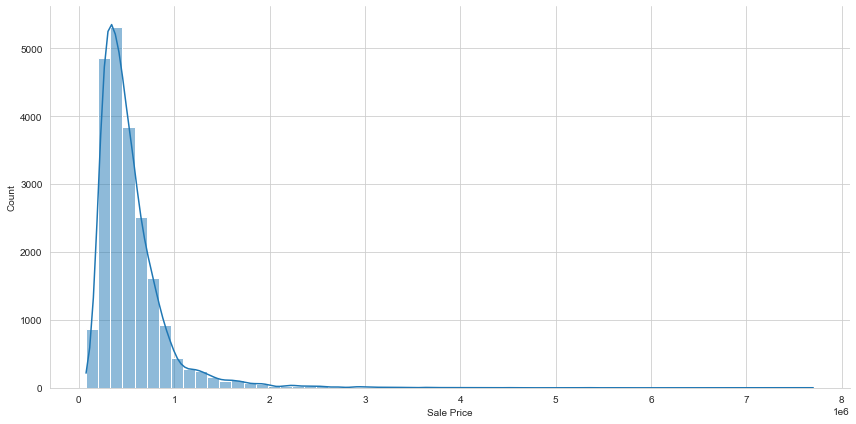

In [255]:
## Plotting

sns.displot(df['Sale Price'], kde = True, aspect = 2, height = 6, bins = 60);


This plot, shows that there is huge amount of outliers. Let's confirm it in boxplot.

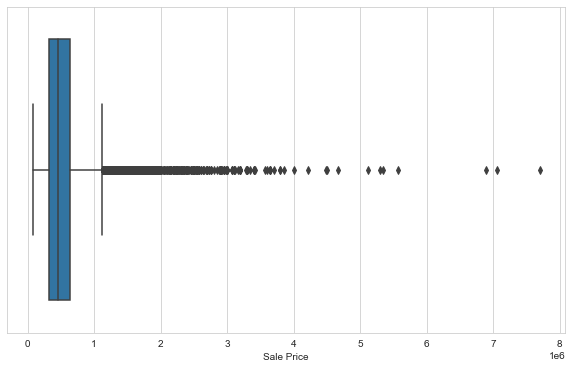

In [256]:
# boxplot

plt.figure(figsize = (10,6))
sns.boxplot(x = 'Sale Price', data = df);

In [286]:
xdf = df.copy()

In [288]:
## Log transformation

def log_transform(dataframe, column):
    return np.log(dataframe[column])

In [289]:
xdf['Sale Price'] = log_transform(xdf, 'Sale Price')

<AxesSubplot:xlabel='ID', ylabel='Sale Price'>

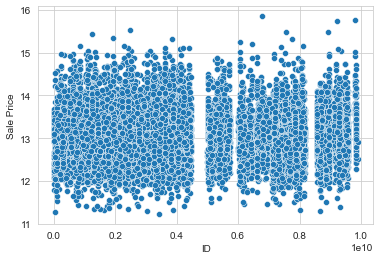

In [290]:
sns.scatterplot(x = 'ID', y = 'Sale Price', data = xdf)

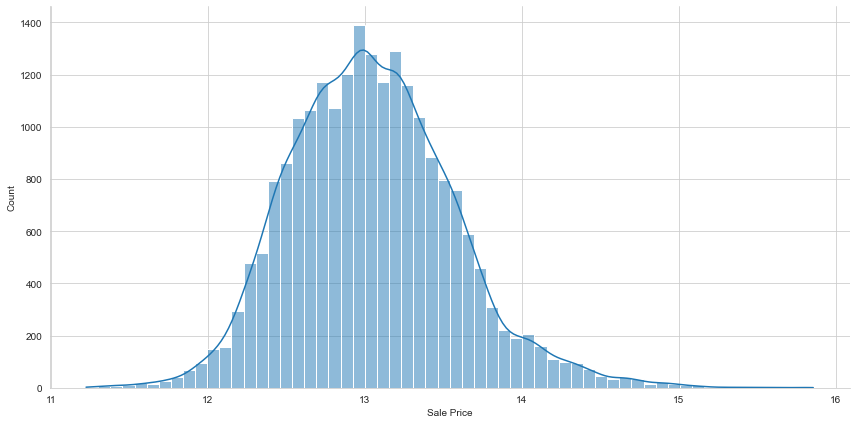

In [291]:
sns.displot(xdf['Sale Price'], kde = True, aspect = 2, height = 6, bins = 60);

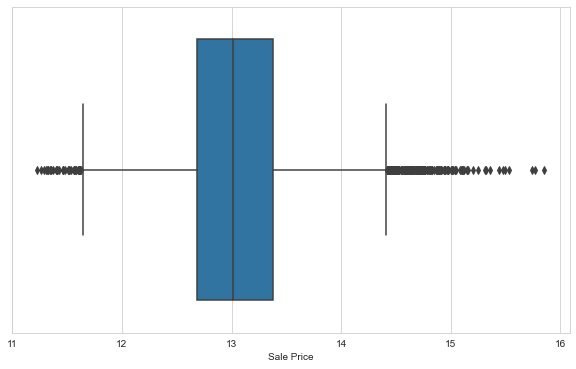

In [292]:
# boxplot

plt.figure(figsize = (10,6))
sns.boxplot(x = 'Sale Price', data = xdf);

It still contains some outliers, let's remove it.

In [293]:
## Let's remove the outliers with Interquartile range

def remove_outliers(dataframe, column):
    q3 = dataframe[column].quantile(0.75)
    q1 = dataframe[column].quantile(0.25)

    iqr = q3 - q1

    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)
    
    df_no_outlier = dataframe[(dataframe[column] < upper_limit) & (dataframe[column] > lower_limit)] 
    
    return df_no_outlier

In [294]:
xdf = remove_outliers(xdf, 'Sale Price')

In [295]:
xdf['Sale Price'].describe()

count    21275.000000
mean        13.029781
std          0.488252
min         11.643954
25%         12.676076
50%         13.017001
75%         13.361380
max         14.414347
Name: Sale Price, dtype: float64

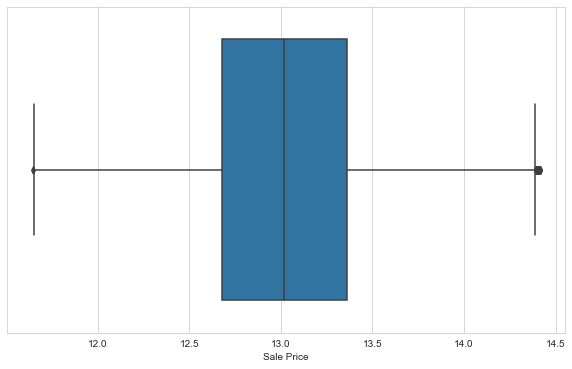

In [296]:
# After removing oultiers
# boxplot

plt.figure(figsize = (10,6))
sns.boxplot(x = 'Sale Price', data = xdf);

## Missing Values

In [297]:
xdf.isnull().sum()

ID                                           0
Date House was Sold                          0
Sale Price                                   0
No of Bedrooms                               0
No of Bathrooms                              4
Flat Area (in Sqft)                          9
Lot Area (in Sqft)                           9
No of Floors                                 0
Waterfront View                              0
No of Times Visited                          0
Condition of the House                       0
Overall Grade                                0
Area of the House from Basement (in Sqft)    3
Basement Area (in Sqft)                      0
Age of House (in Years)                      0
Renovated Year                               0
Zipcode                                      1
Latitude                                     1
Longitude                                    1
Living Area after Renovation (in Sqft)       1
Lot Area after Renovation (in Sqft)          0
dtype: int64

In [298]:
# Let's list them out

total = xdf.isnull().sum().sort_values(ascending = False)
percent = (xdf.isnull().sum() / xdf.isnull().count()).sort_values(ascending = False)
types = xdf[percent.index].dtypes

missing_data = pd.concat([total, percent, types], axis = 1, keys = ['Total', 'Percent','Types'])
missing_data.head(10)

,Total,Percent,Types
Flat Area (in Sqft),9,0.000423,float64
Lot Area (in Sqft),9,0.000423,float64
No of Bathrooms,4,0.000188,float64
Area of the House from Basement (in Sqft),3,0.000141,float64
Longitude,1,0.000047,float64
Latitude,1,0.000047,float64
Zipcode,1,0.000047,float64
Living Area after Renovation (in Sqft),1,0.000047,float64
Lot Area after Renovation (in Sqft),0,0.000000,int64
No of Floors,0,0.000000,float64


In [299]:
## imputing all of them with median 

def impute_missing(dataframe, columns):
    dataframe[columns].fillna(dataframe[columns].median(), inplace = True)

In [300]:
impute_missing(xdf, 'Flat Area (in Sqft)')
impute_missing(xdf, 'Lot Area (in Sqft)')
impute_missing(xdf, 'Sale Price')
impute_missing(xdf, 'No of Bathrooms')
impute_missing(xdf, 'Area of the House from Basement (in Sqft)')
impute_missing(xdf, 'Longitude')
impute_missing(xdf, 'Latitude')
impute_missing(xdf, 'Zipcode')
impute_missing(xdf, 'Living Area after Renovation (in Sqft)')

In [301]:
# Let's check it again

xdf.isnull().sum()

ID                                           0
Date House was Sold                          0
Sale Price                                   0
No of Bedrooms                               0
No of Bathrooms                              0
Flat Area (in Sqft)                          0
Lot Area (in Sqft)                           0
No of Floors                                 0
Waterfront View                              0
No of Times Visited                          0
Condition of the House                       0
Overall Grade                                0
Area of the House from Basement (in Sqft)    0
Basement Area (in Sqft)                      0
Age of House (in Years)                      0
Renovated Year                               0
Zipcode                                      0
Latitude                                     0
Longitude                                    0
Living Area after Renovation (in Sqft)       0
Lot Area after Renovation (in Sqft)          0
dtype: int64

## Univariate Analysis

In [302]:
categorical_df = xdf.select_dtypes(include = 'object')
numerical_df = xdf.select_dtypes(exclude = 'object')

In [303]:
# Let's check all the numerical variables

numerical_df

,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft)
0,7129300520,12.309982,3,1.00,1180.0,5650.0,1.0,7,1180.0,0,63,0,98178.0,47.5112,-122.257,1340.0,5650
1,6414100192,13.195614,3,2.25,2570.0,7242.0,2.0,7,2170.0,400,67,1991,98125.0,47.7210,-122.319,1690.0,7639
2,5631500400,12.100712,2,1.00,770.0,10000.0,1.0,6,770.0,0,85,0,98028.0,47.7379,-122.233,2720.0,8062
3,2487200875,13.311329,4,3.00,1960.0,5000.0,1.0,7,1050.0,910,53,0,98136.0,47.5208,-122.393,1360.0,5000
4,1954400510,13.142166,3,2.00,1680.0,8080.0,1.0,8,1680.0,0,31,0,98074.0,47.6168,-122.045,1800.0,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,12.793859,3,2.50,1530.0,1131.0,3.0,8,1530.0,0,9,0,98103.0,47.6993,-122.346,1530.0,1509
21609,6600060120,12.899220,4,2.50,2310.0,5813.0,2.0,8,2310.0,0,4,0,98146.0,47.5107,-122.362,1830.0,7200
21610,1523300141,12.904459,2,0.75,1020.0,1350.0,2.0,7,1020.0,0,9,0,98144.0,47.5944,-122.299,1020.0,2007
21611,291310100,12.899220,3,2.50,1600.0,2388.0,2.0,8,1600.0,0,14,0,98027.0,47.5345,-122.069,1410.0,1287


In [304]:
numerical_df.describe()

,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft)
count,2.127500e+04,21275.000000,21275.000000,21275.000000,21275.000000,2.127500e+04,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000,21275.000000
mean,4.589553e+09,13.029781,3.361551,2.096287,2046.990787,1.494686e+04,1.490317,7.604700,1763.114313,283.839201,46.975229,81.800329,98078.102233,47.559567,-122.213516,1969.445358,12678.415605
std,2.877942e+09,0.488252,0.921140,0.741946,851.076970,4.094150e+04,0.539086,1.071645,783.669085,428.920933,29.297996,395.701819,53.401850,0.139148,0.141400,663.308537,27213.088771
min,1.000102e+06,11.643954,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,290.000000,0.000000,3.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.125059e+09,12.676076,3.000000,1.500000,1420.000000,5.023000e+03,1.000000,7.000000,1190.000000,0.000000,21.000000,0.000000,98033.000000,47.468850,-122.329000,1480.000000,5093.000000
50%,3.905040e+09,13.017001,3.000000,2.250000,1900.000000,7.566000e+03,1.500000,7.000000,1550.000000,0.000000,43.000000,0.000000,98065.000000,47.570700,-122.230000,1830.000000,7596.000000
75%,7.329901e+09,13.361380,4.000000,2.500000,2520.000000,1.051350e+04,2.000000,8.000000,2180.000000,550.000000,66.000000,0.000000,98118.000000,47.678600,-122.124000,2340.000000,10007.500000
max,9.900000e+09,14.414347,33.000000,7.500000,7620.000000,1.651359e+06,3.500000,10.000000,7320.000000,2850.000000,118.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


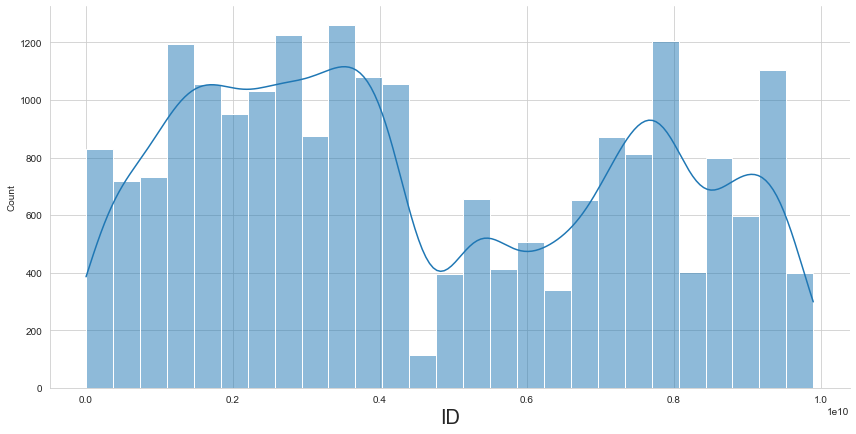

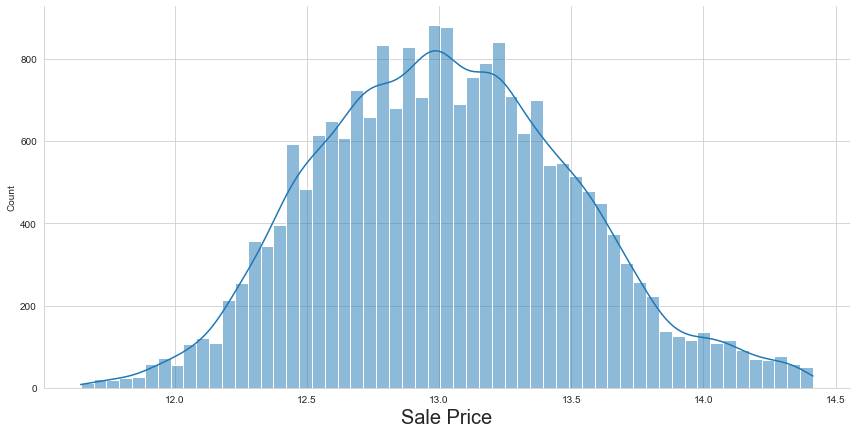

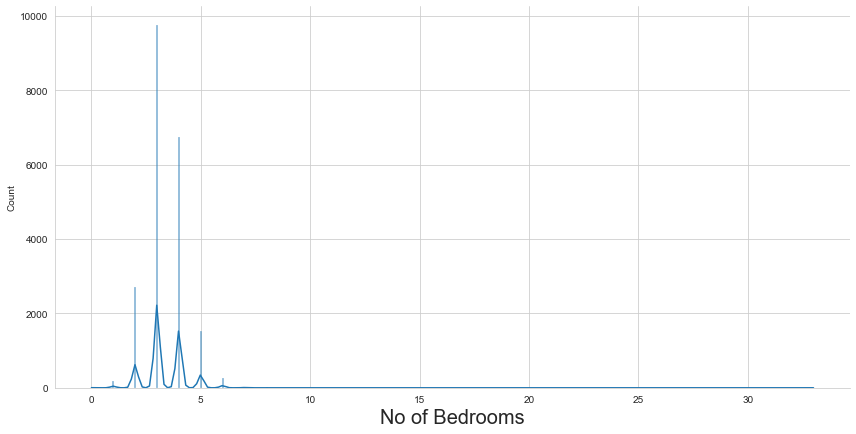

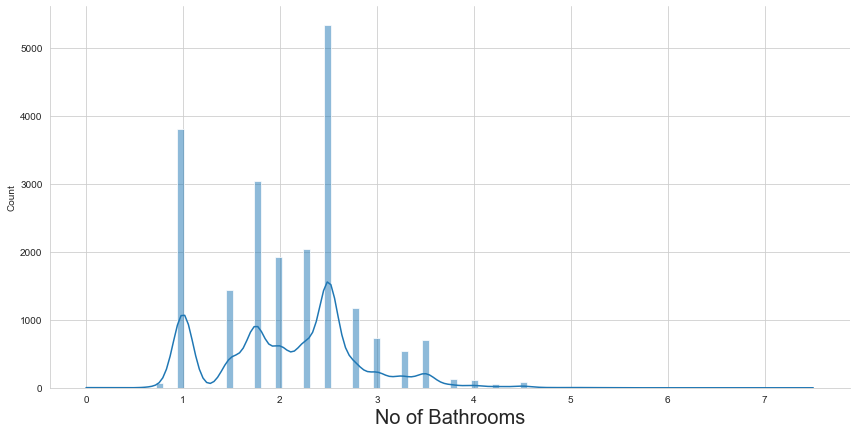

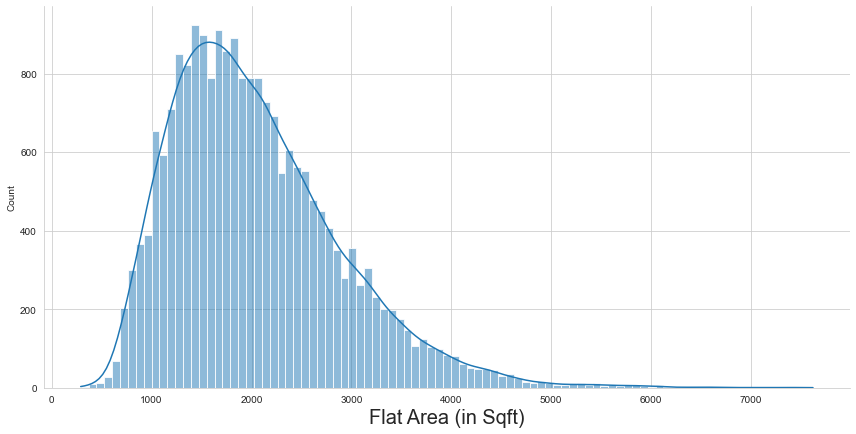

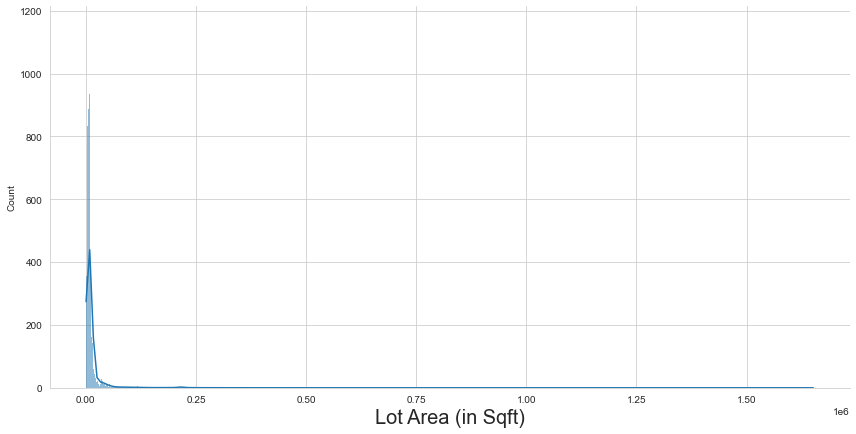

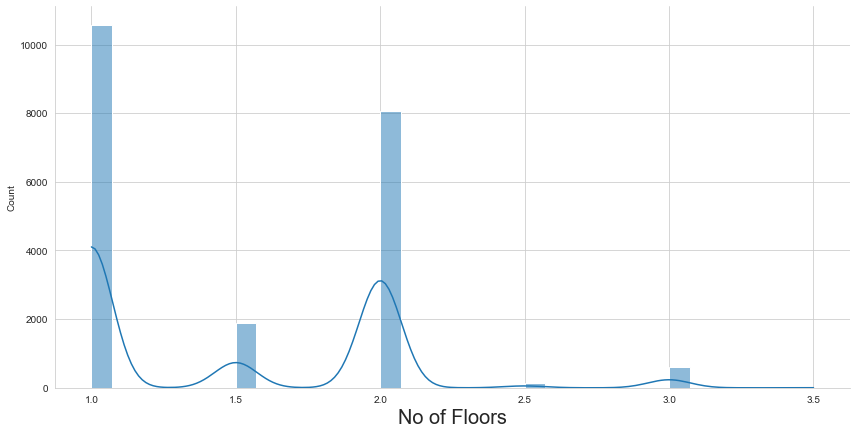

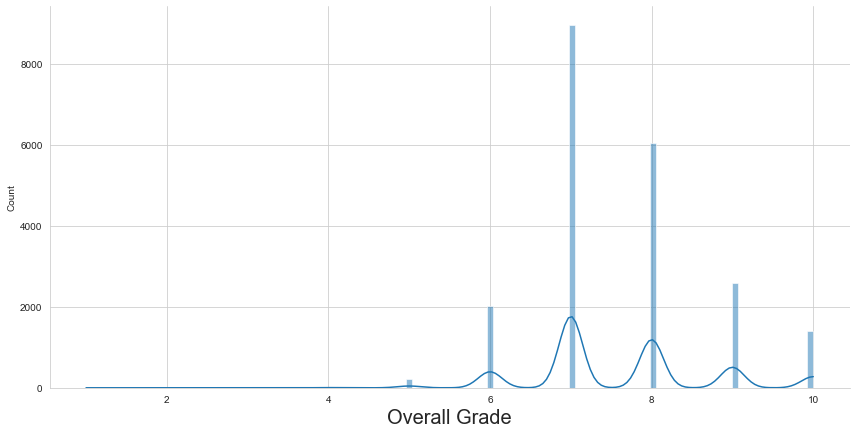

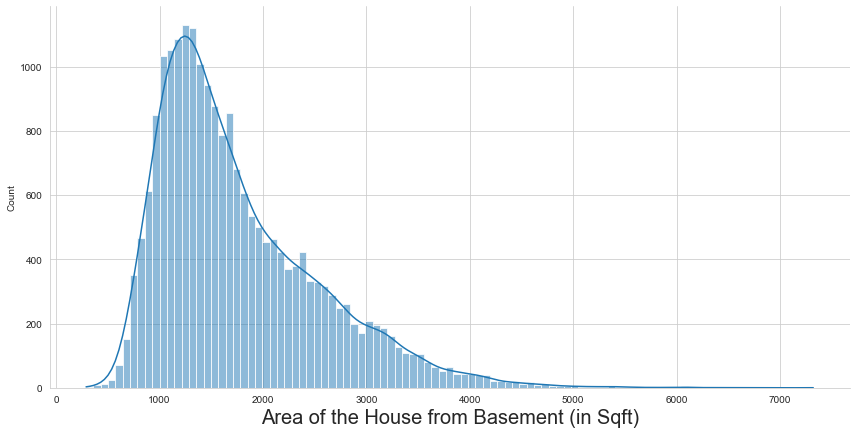

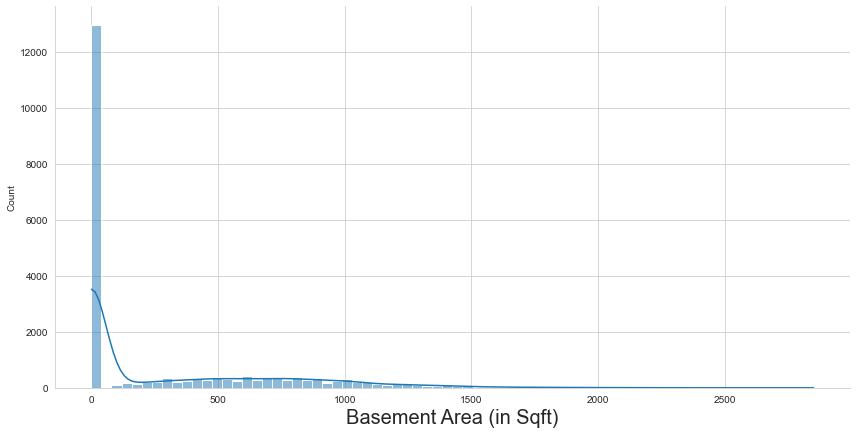

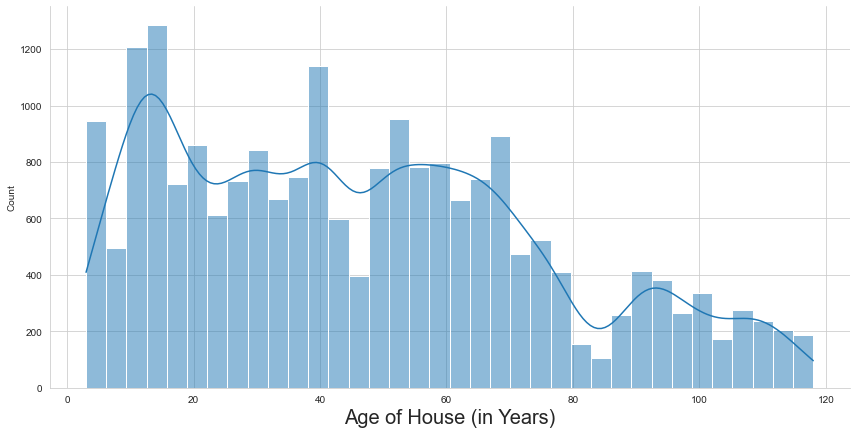

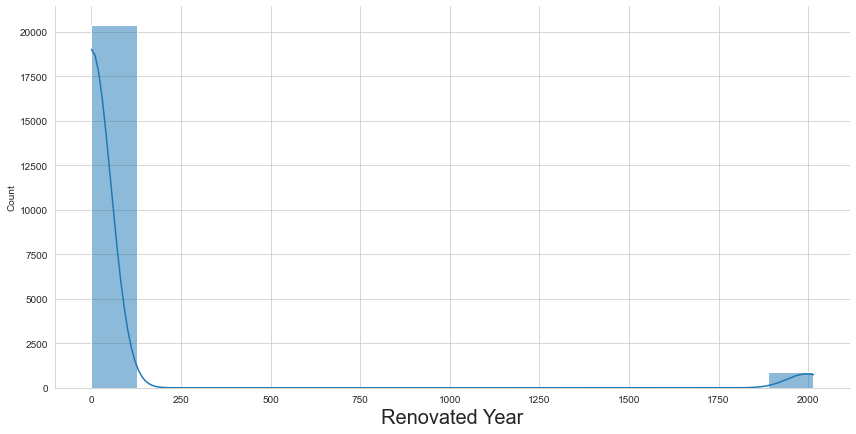

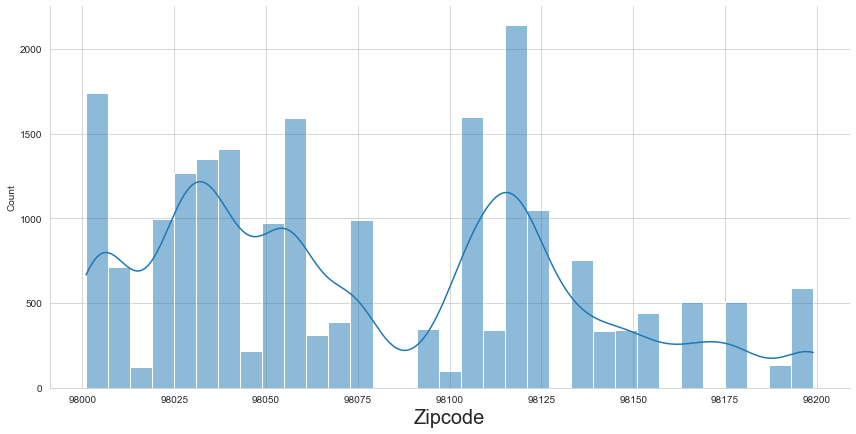

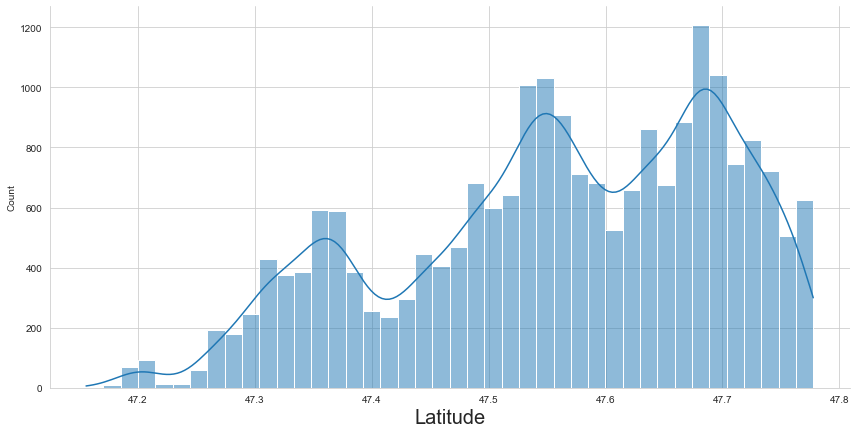

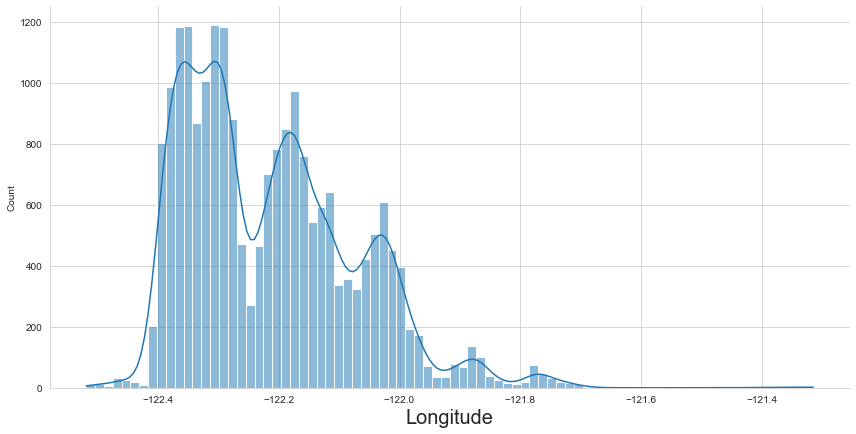

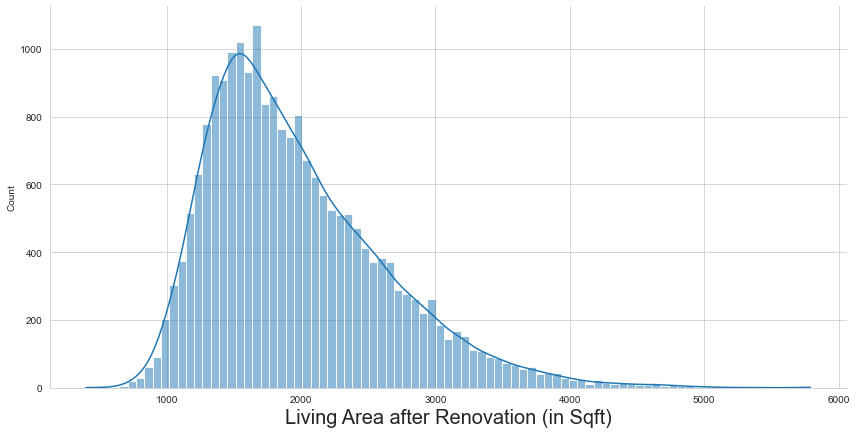

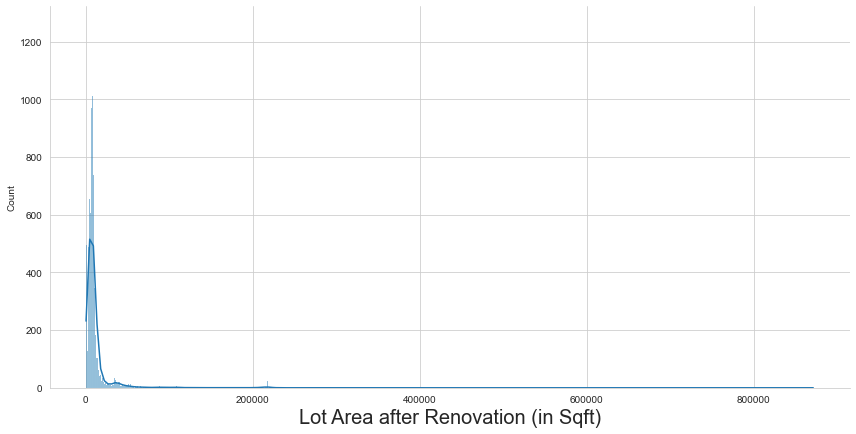

In [305]:
## plotting each atrribute

for i in numerical_df:
    sns.displot(x = i, data = xdf, aspect = 2, height = 6, kde = True);
    plt.xlabel(i, fontsize = 20)

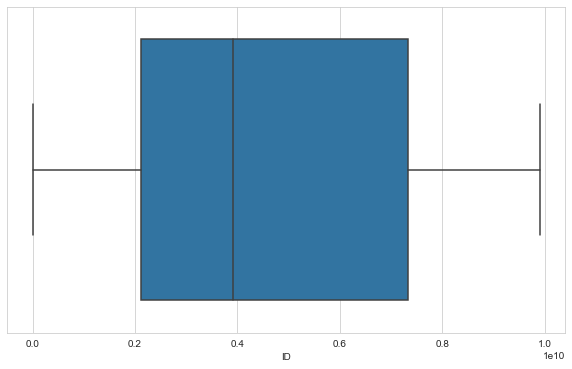

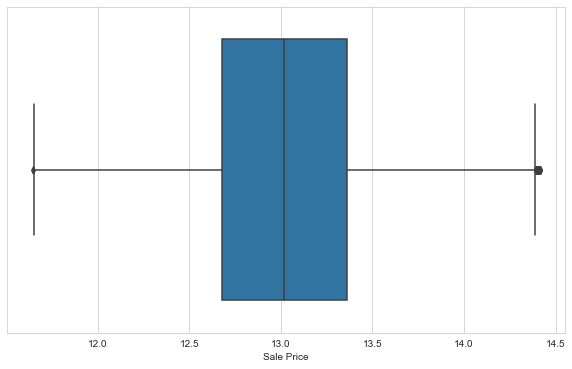

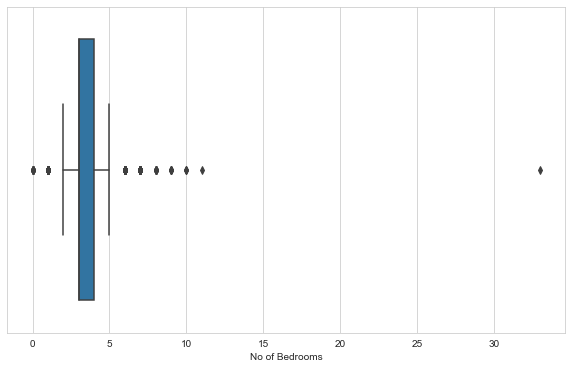

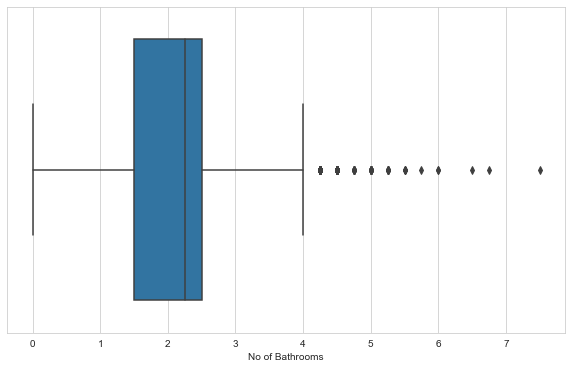

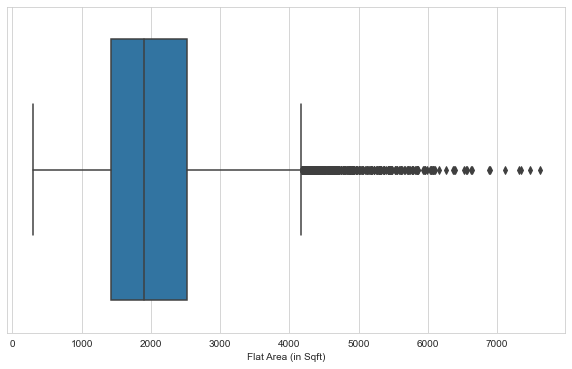

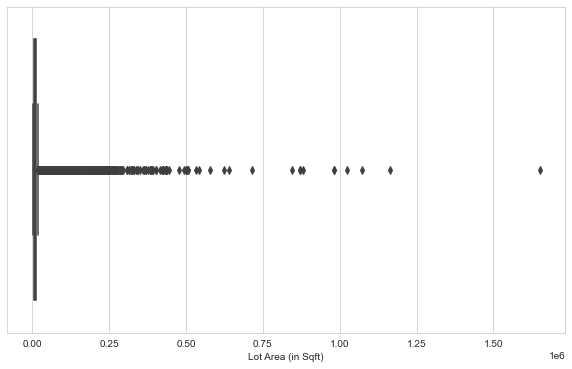

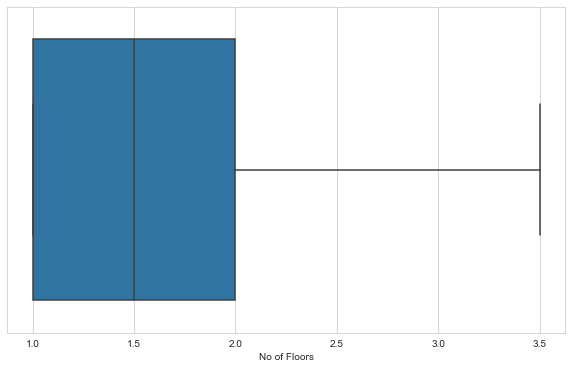

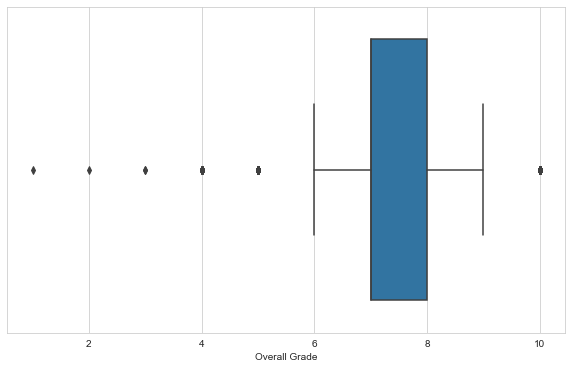

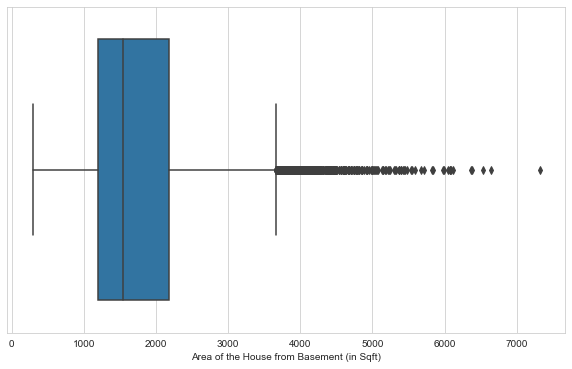

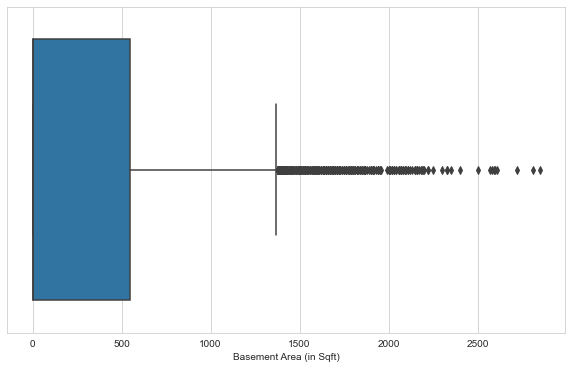

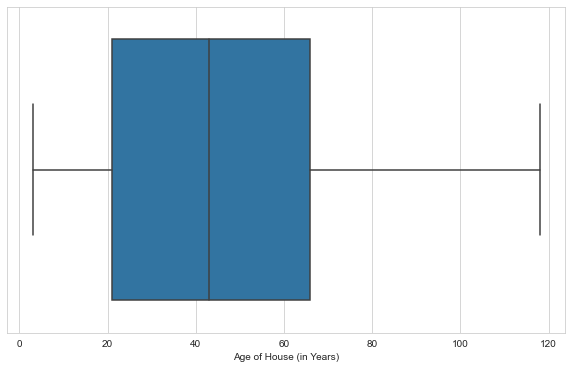

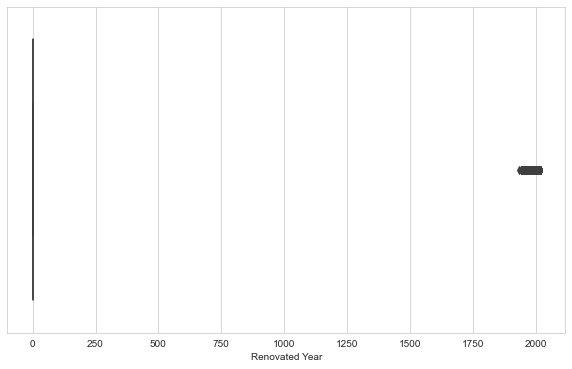

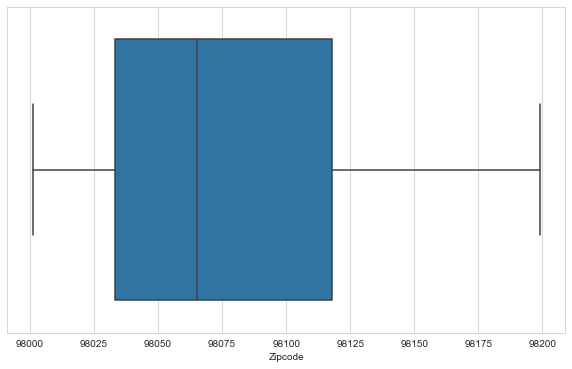

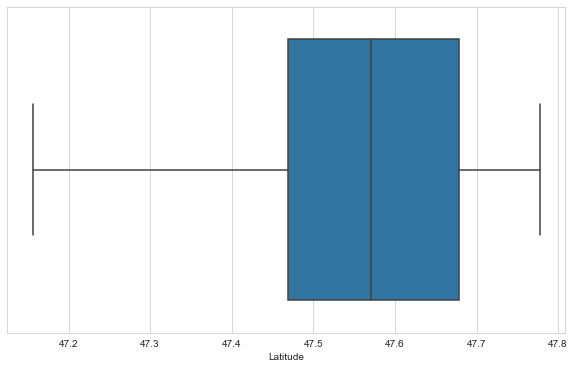

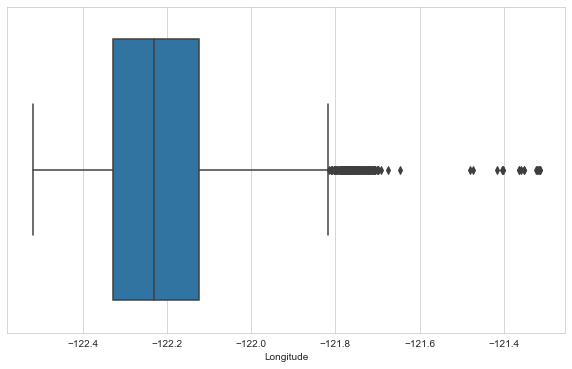

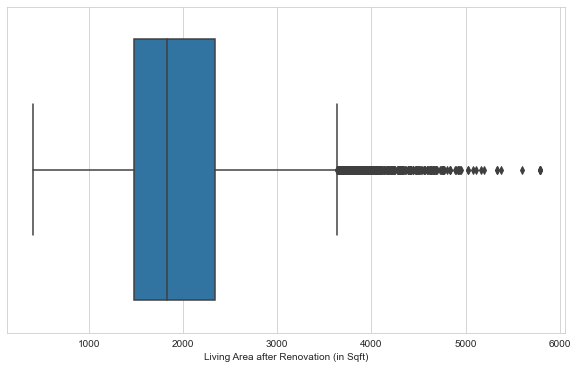

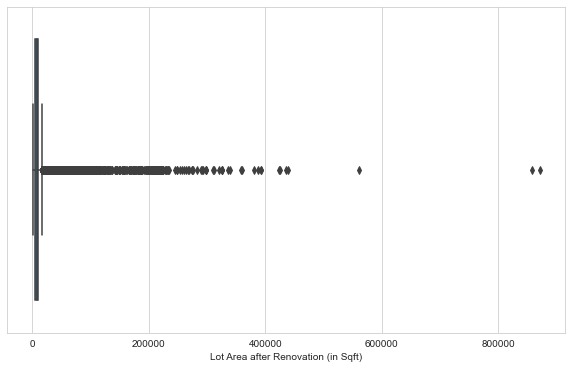

In [306]:
## boxplots

for i in numerical_df:
    plt.figure(figsize = (10,6))
    sns.boxplot(x = i, data = xdf);
    plt.xlabel(i, fontsize = 10)

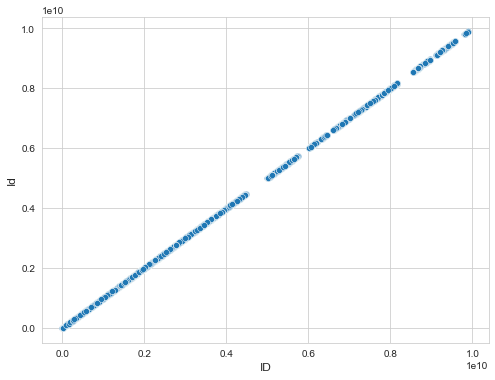

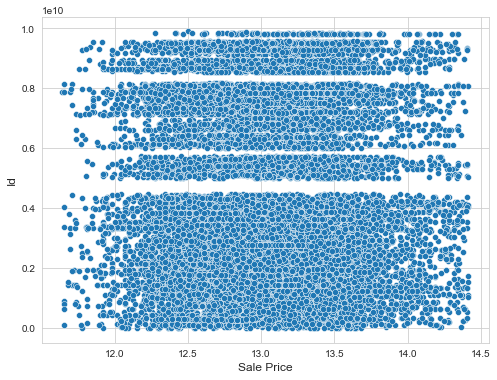

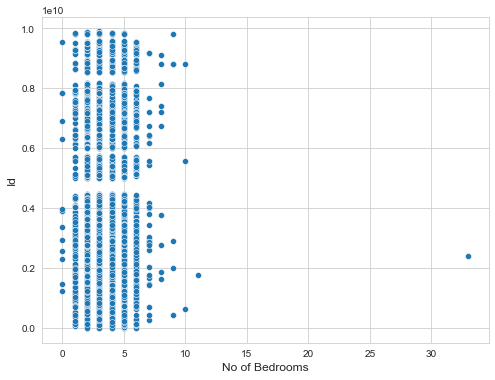

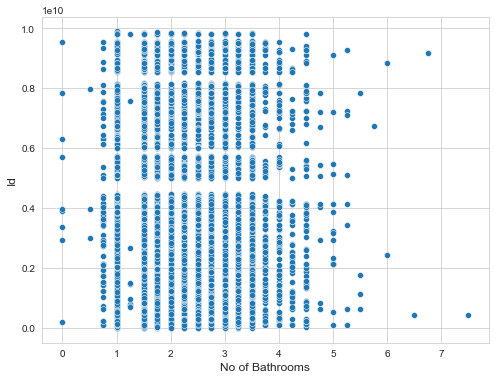

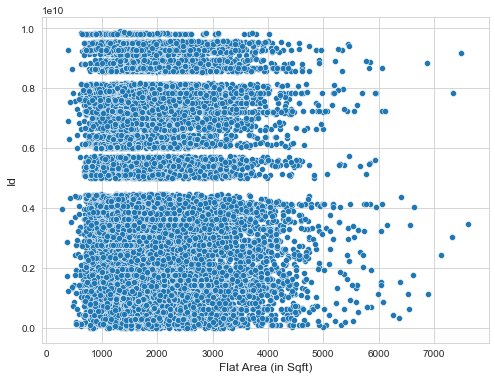

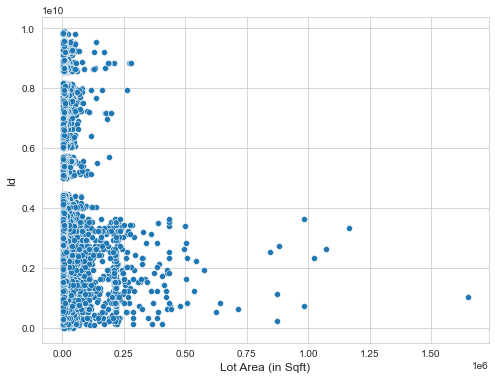

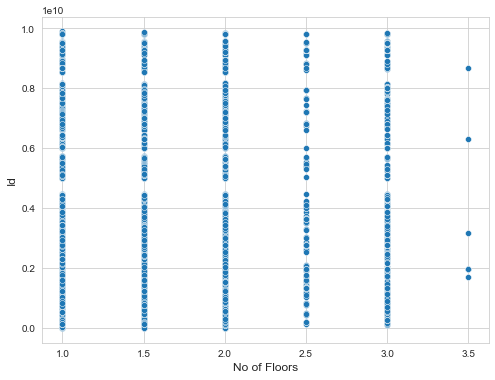

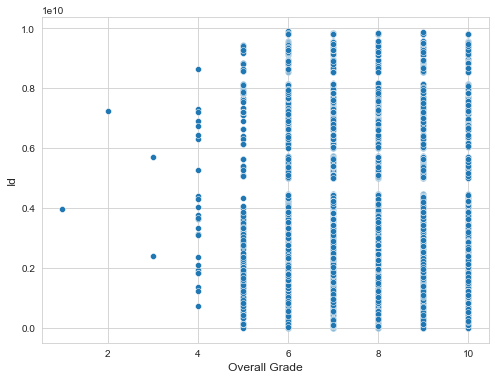

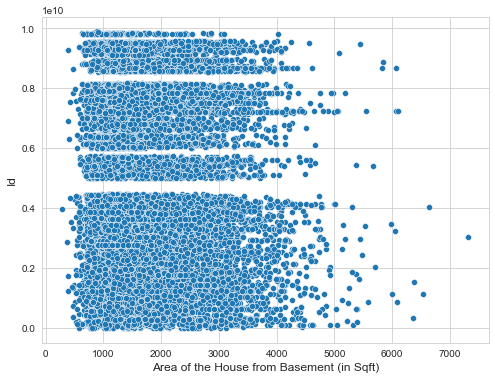

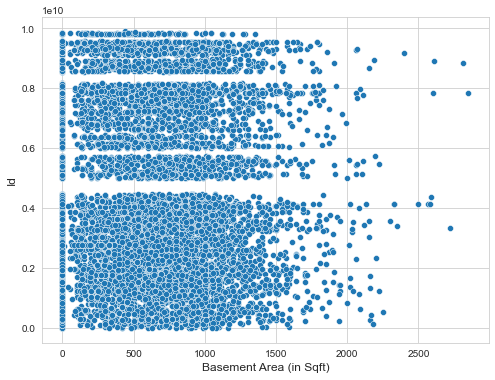

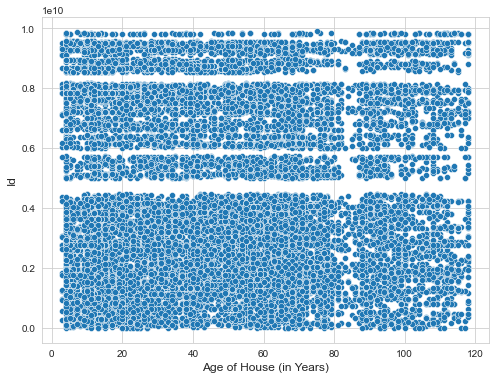

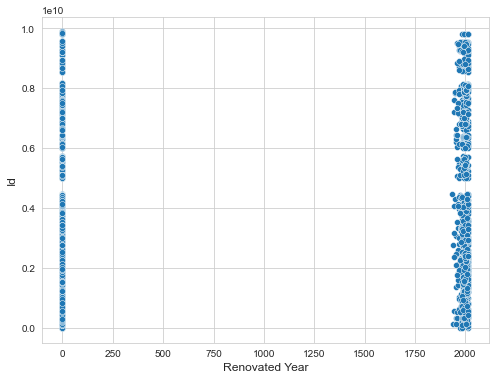

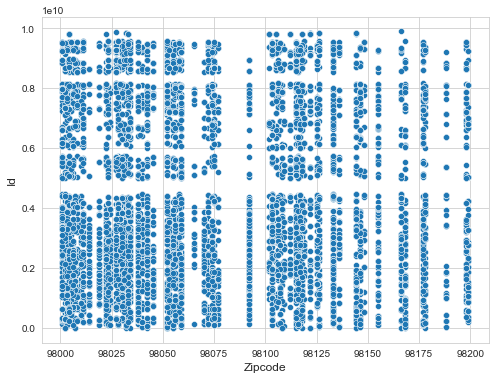

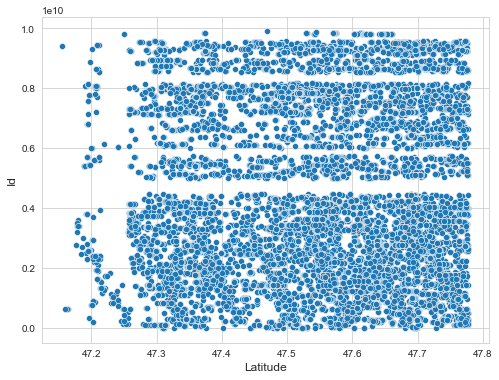

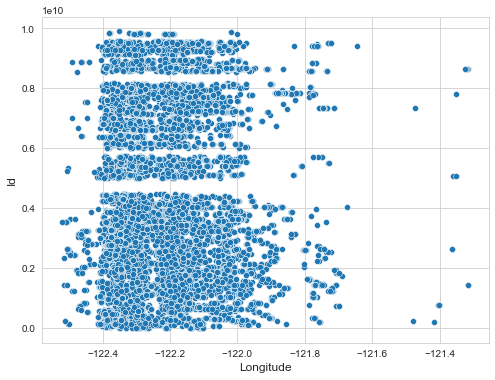

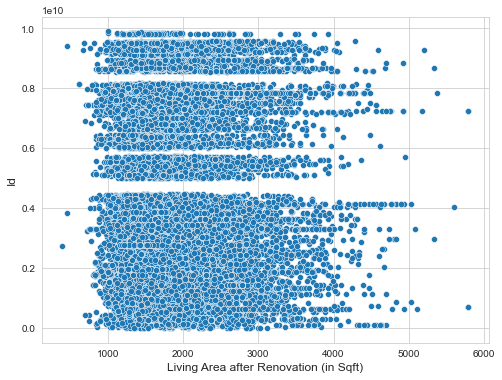

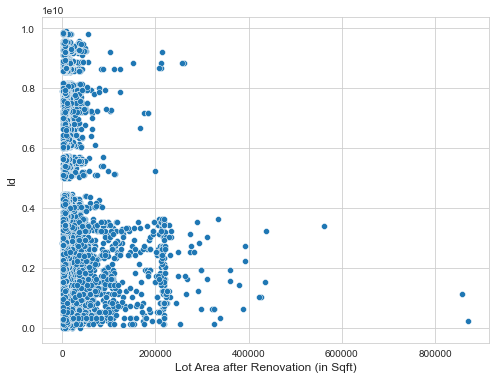

In [318]:
# Scatter plots

for i in numerical_df:
    plt.figure(figsize = (8,6))
    sns.scatterplot(x = i, y = 'ID', data = xdf);
    plt.xlabel(i, fontsize = 12)
    plt.ylabel('Id', fontsize = 12)

## Let's fix the outliers and skewed dataset

In [476]:
xxdf = xdf.copy()

According to my observations: 
- Columns with Skewness and Outliers ('No of Bedrooms','No of Bathrooms','Flat Area (in Sqft)','Lot Area (in Sqft)','Area of the House from Basement (in Sqft)','Basement Area (in Sqft)','Longitude','Living Area after Renovation (in Sqft)','Lot Area after Renovation (in Sqft)')


In [477]:
outliers_df = ['No of Bedrooms','No of Bathrooms','Flat Area (in Sqft)','Lot Area (in Sqft)','Area of the House from Basement (in Sqft)','Basement Area (in Sqft)','Longitude','Living Area after Renovation (in Sqft)','Lot Area after Renovation (in Sqft)']

In [478]:
for i in outliers_df:
    xxdf = remove_outliers(xxdf, i)

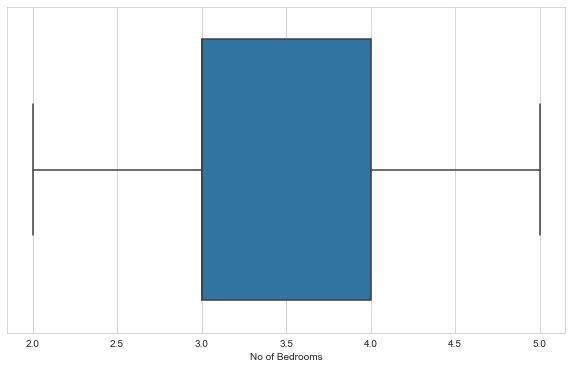

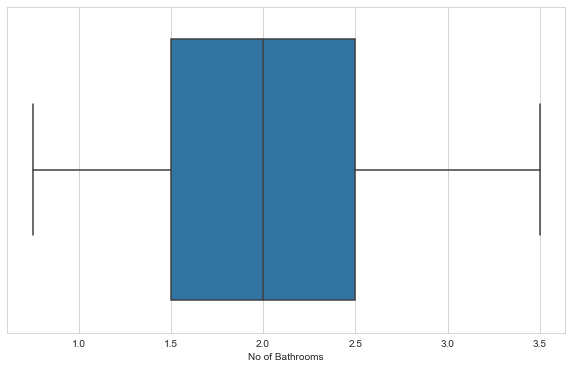

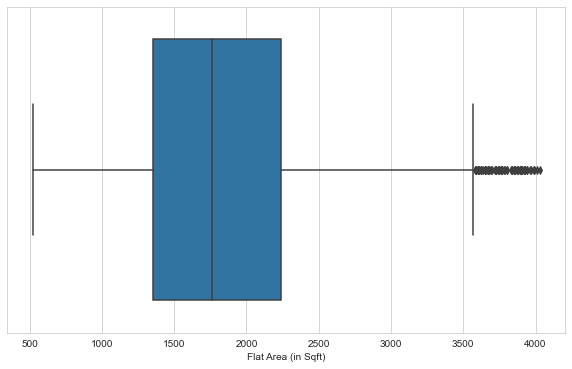

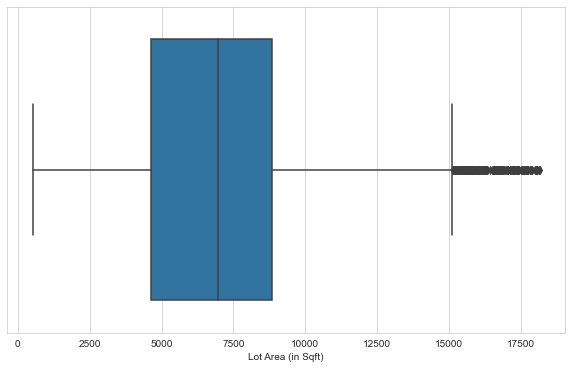

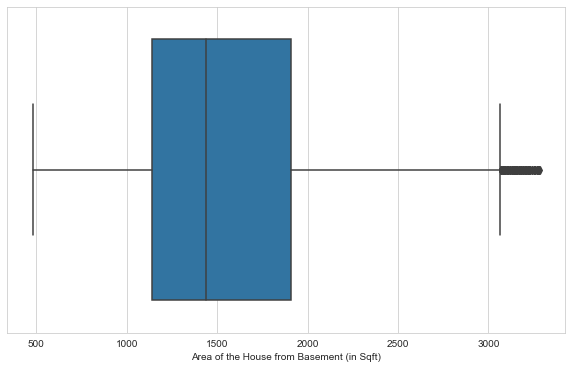

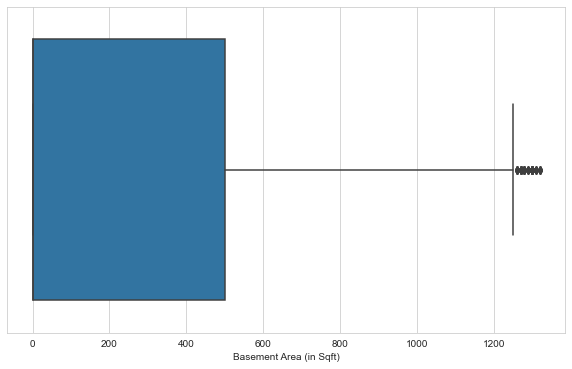

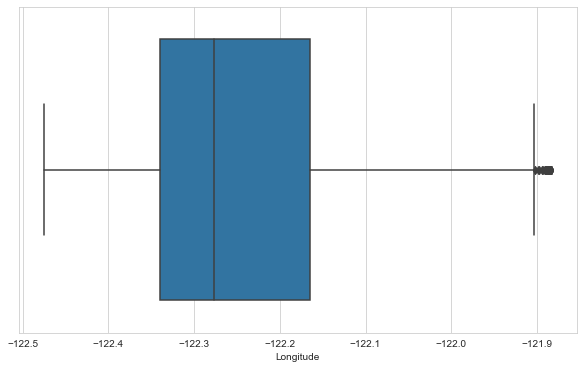

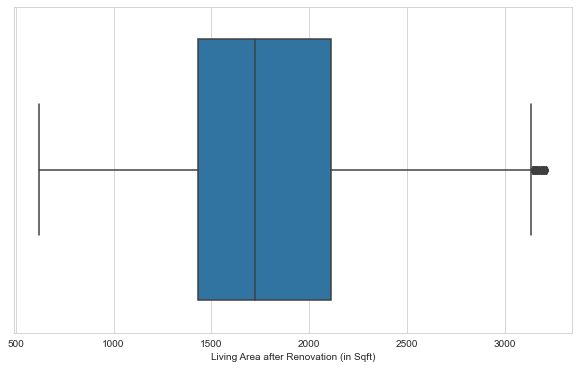

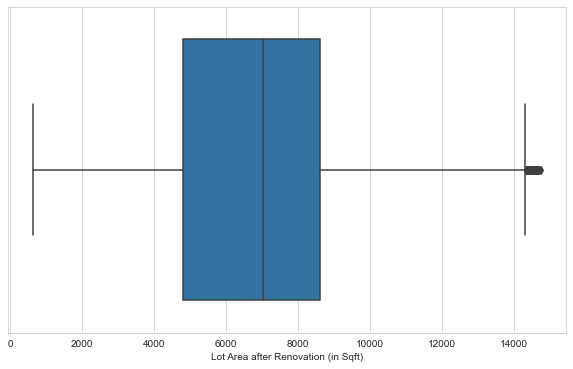

In [479]:
for i in outliers_df:
    plt.figure(figsize = (10,6))
    sns.boxplot(x = i, data = xxdf);
    plt.xlabel(i, fontsize = 10)

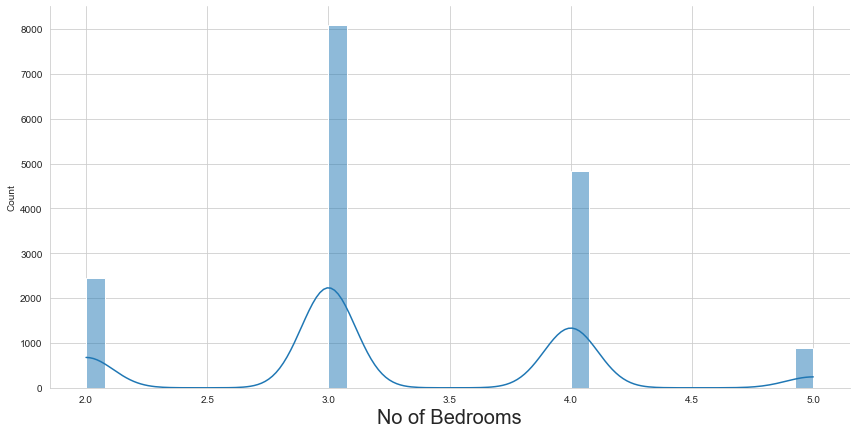

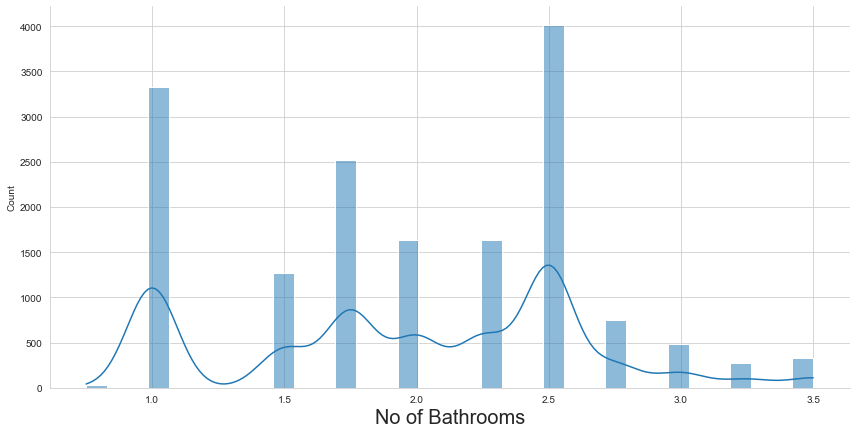

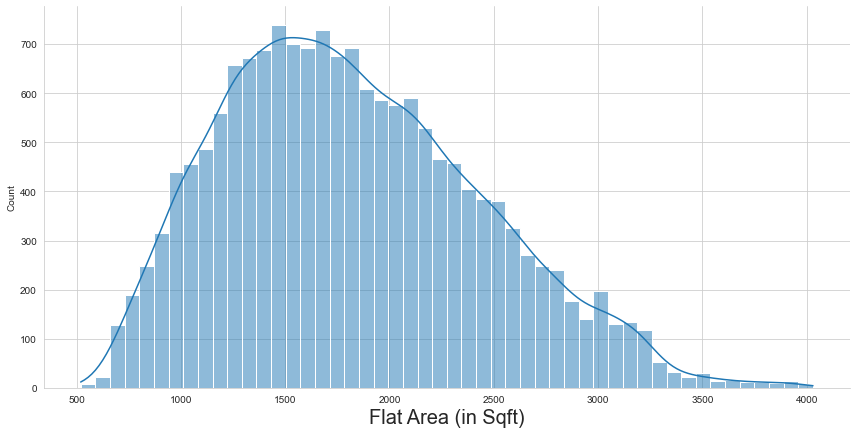

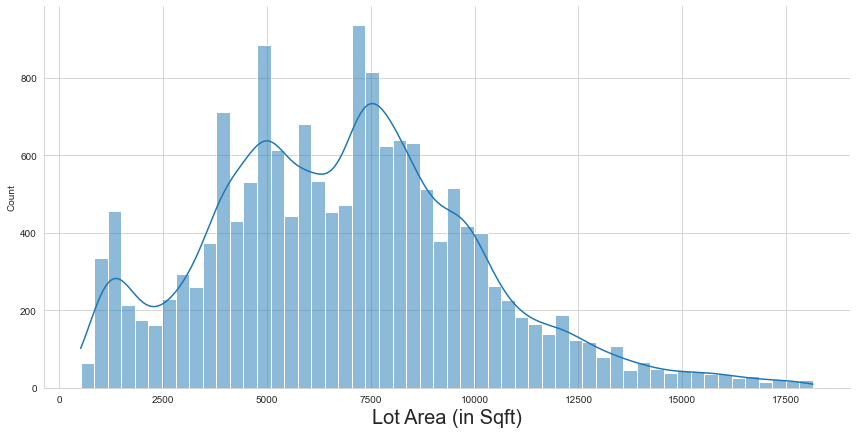

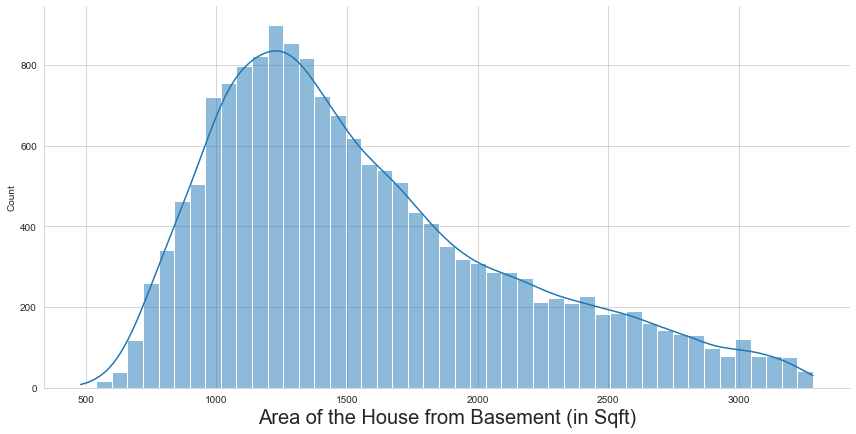

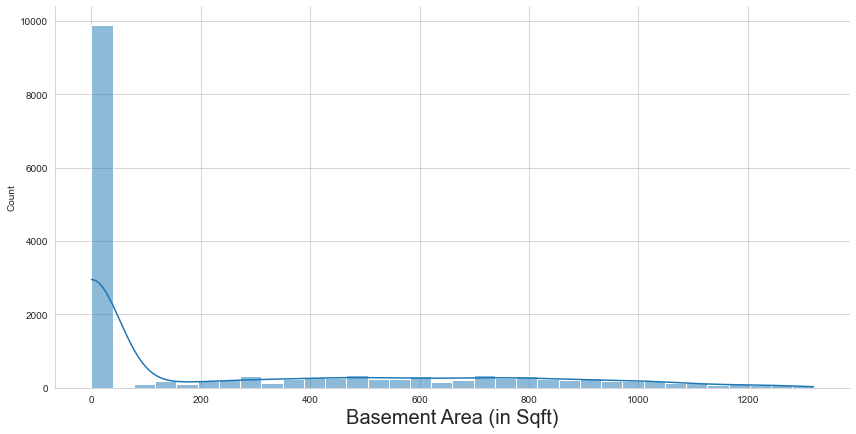

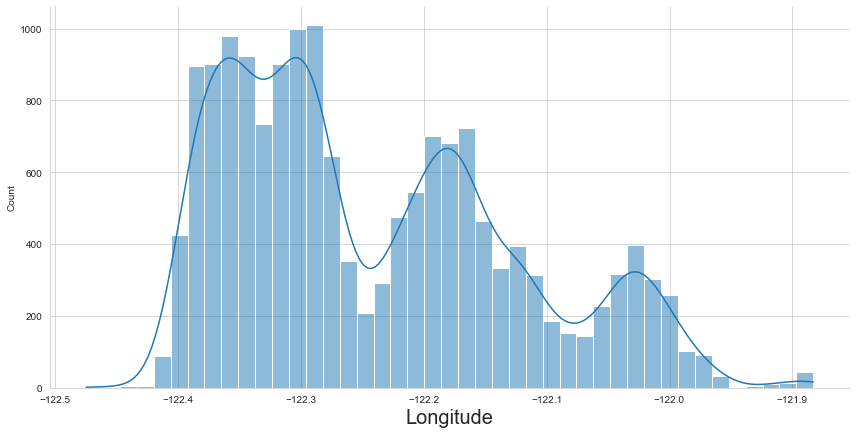

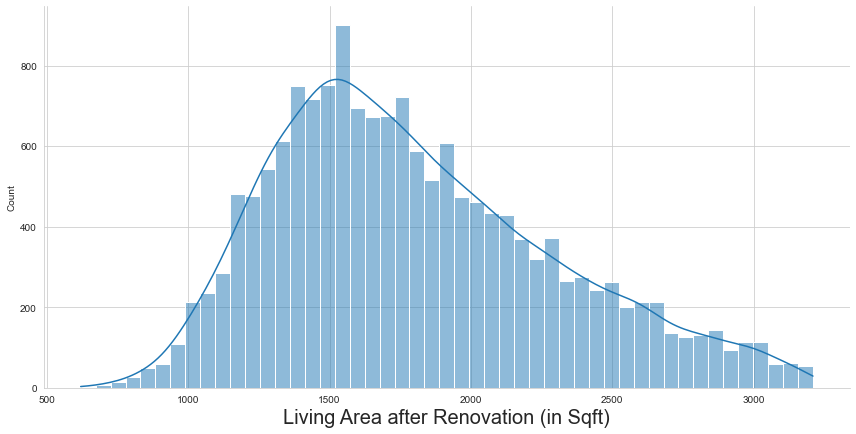

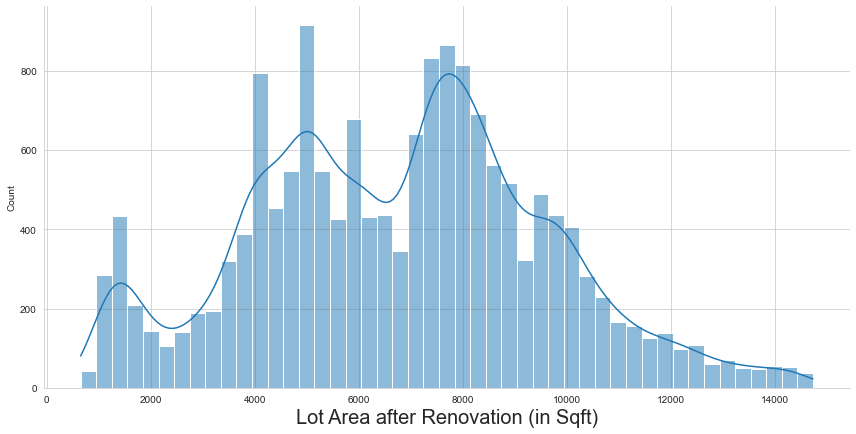

In [480]:
## plotting each atrribute

for i in outliers_df:
    sns.displot(x = i, data = xxdf, aspect = 2, height = 6, kde = True);
    plt.xlabel(i, fontsize = 20)

In [481]:
xxdf.describe()

,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft)
count,1.627900e+04,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000
mean,4.711661e+09,12.948686,3.254623,1.979391,1825.309171,6887.510965,1.468057,7.414645,1575.638491,249.684624,49.111309,73.825235,98083.266908,47.562015,-122.241775,1800.219792,6769.521838
std,2.864588e+09,0.445529,0.774945,0.656618,618.025364,3218.518900,0.547442,0.901090,581.849270,362.811088,30.079708,376.761381,54.308478,0.139697,0.116714,498.230628,2830.311991
min,2.800031e+06,11.643954,2.000000,0.750000,520.000000,520.000000,1.000000,4.000000,480.000000,0.000000,3.000000,0.000000,98001.000000,47.189500,-122.475000,620.000000,651.000000
25%,2.293951e+09,12.628067,3.000000,1.500000,1350.000000,4640.000000,1.000000,7.000000,1140.000000,0.000000,23.000000,0.000000,98033.000000,47.472650,-122.340000,1430.000000,4800.000000
50%,4.037800e+09,12.947057,3.000000,2.000000,1760.000000,6947.000000,1.000000,7.000000,1440.000000,0.000000,49.000000,0.000000,98092.000000,47.575400,-122.277000,1720.000000,7020.000000
75%,7.399301e+09,13.256894,4.000000,2.500000,2240.000000,8828.000000,2.000000,8.000000,1910.000000,500.000000,69.000000,0.000000,98122.000000,47.681700,-122.165000,2110.000000,8604.000000
max,9.900000e+09,14.408837,5.000000,3.500000,4030.000000,18144.000000,3.500000,10.000000,3284.000000,1320.000000,118.000000,2015.000000,98199.000000,47.777600,-121.883000,3210.000000,14733.000000


## Bivariate Analysis

In [482]:
categorical_df

,Date House was Sold,Waterfront View,No of Times Visited,Condition of the House
0,14 October 2017,No,None,Fair
1,14 December 2017,No,None,Fair
2,15 February 2016,No,None,Fair
3,14 December 2017,No,None,Excellent
4,15 February 2016,No,None,Fair
...,...,...,...,...
21608,14 May 2017,No,None,Fair
21609,15 February 2016,No,None,Fair
21610,14 June 2017,No,None,Fair
21611,15 January 2016,No,None,Fair


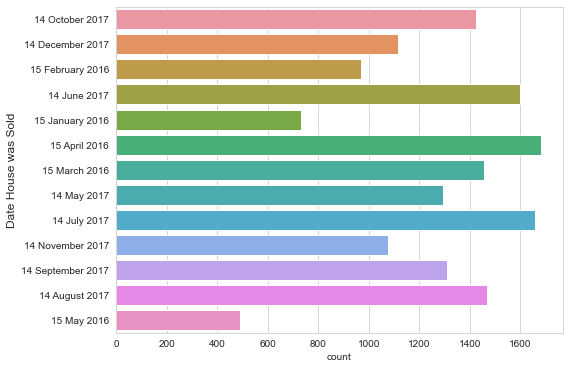

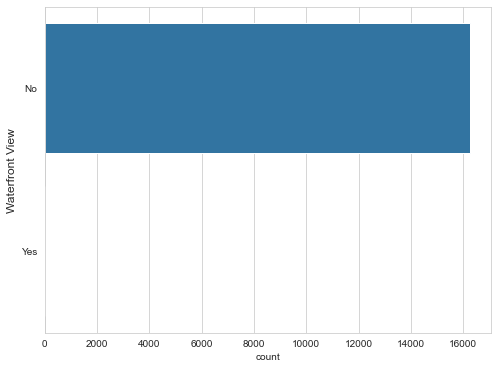

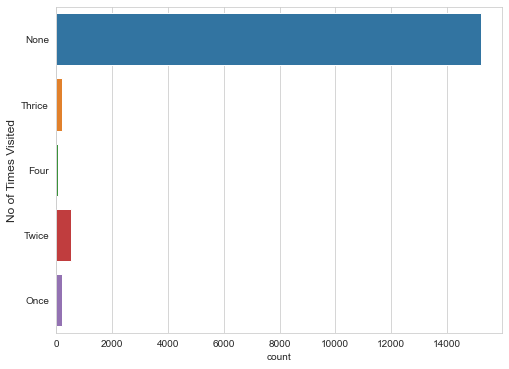

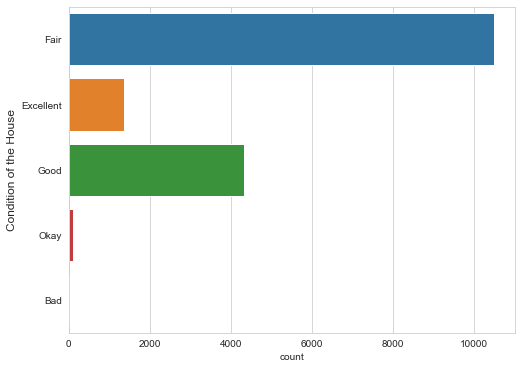

In [483]:
# checking their countplot

for i in categorical_df:
    plt.figure(figsize = (8,6))
    sns.countplot(y = i, data = xxdf);
    plt.ylabel(i, fontsize = 12)

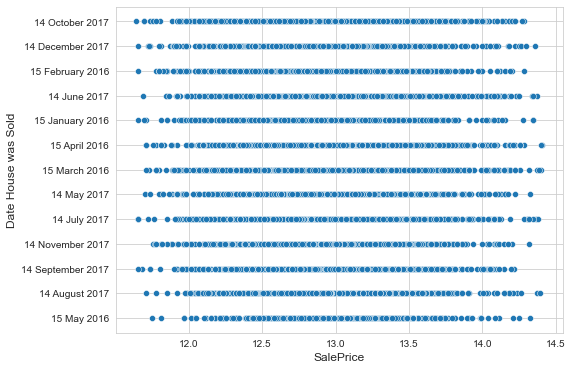

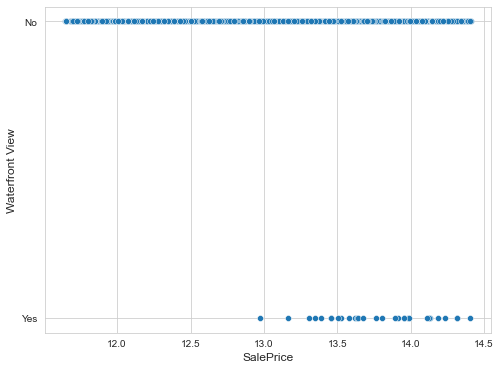

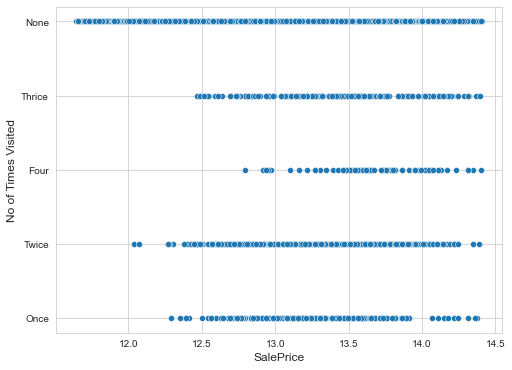

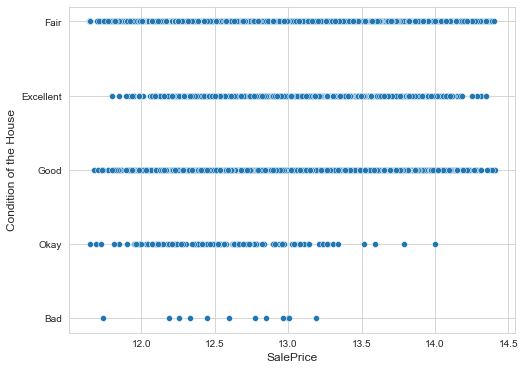

In [484]:
## Let's check in terms of 'SalePrice'

for i in categorical_df:
    plt.figure(figsize = (8,6))
    sns.scatterplot(y = i, x = 'Sale Price', data = xxdf);
    plt.xlabel("SalePrice", fontsize = 12)
    plt.ylabel(i, fontsize = 12)

## Feature Engineering

In [485]:
# converting from string to categorical

mapping = {'None' : "0",
           'Once' : '1',
           'Twice' : '2',
           'Thrice' : '3',
           'Four' : '4'}

xxdf['No of Times Visited'] = xxdf['No of Times Visited'].map(mapping)

In [486]:
xxdf['No of Times Visited'].unique()

array(['0', '3', '4', '2', '1'], dtype=object)

In [487]:
# new variable creation

xxdf['Ever Renovated'] = np.where(xxdf['Renovated Year'] == 0, 'No', 'Yes')

In [488]:
#manipulating datetime variable

xxdf['Purchase Year'] = pd.DatetimeIndex(xxdf['Date House was Sold']).year

In [489]:
xxdf['Years Since Renovation'] = np.where(xxdf['Ever Renovated'] == 'Yes',
                                                     abs(xxdf['Purchase Year'] - 
                                                        xxdf['Renovated Year']), 0)

In [490]:
xxdf.head()

,ID,Date House was Sold,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,Condition of the House,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Renovated Year,Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever Renovated,Purchase Year,Years Since Renovation
0,7129300520,14 October 2017,12.309982,3,1.00,1180.0,5650.0,1.0,No,0,Fair,7,1180.0,0,63,0,98178.0,47.5112,-122.257,1340.0,5650,No,2017,0
1,6414100192,14 December 2017,13.195614,3,2.25,2570.0,7242.0,2.0,No,0,Fair,7,2170.0,400,67,1991,98125.0,47.7210,-122.319,1690.0,7639,Yes,2017,26
2,5631500400,15 February 2016,12.100712,2,1.00,770.0,10000.0,1.0,No,0,Fair,6,770.0,0,85,0,98028.0,47.7379,-122.233,2720.0,8062,No,2016,0
3,2487200875,14 December 2017,13.311329,4,3.00,1960.0,5000.0,1.0,No,0,Excellent,7,1050.0,910,53,0,98136.0,47.5208,-122.393,1360.0,5000,No,2017,0
4,1954400510,15 February 2016,13.142166,3,2.00,1680.0,8080.0,1.0,No,0,Fair,8,1680.0,0,31,0,98074.0,47.6168,-122.045,1800.0,7503,No,2016,0


In [491]:
# dropping redundant variables

xxdf.drop( columns = ['Purchase Year', 'Date House was Sold', 'Renovated Year'], inplace = True)

In [492]:
xxdf.head()

,ID,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Waterfront View,No of Times Visited,Condition of the House,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Ever Renovated,Years Since Renovation
0,7129300520,12.309982,3,1.00,1180.0,5650.0,1.0,No,0,Fair,7,1180.0,0,63,98178.0,47.5112,-122.257,1340.0,5650,No,0
1,6414100192,13.195614,3,2.25,2570.0,7242.0,2.0,No,0,Fair,7,2170.0,400,67,98125.0,47.7210,-122.319,1690.0,7639,Yes,26
2,5631500400,12.100712,2,1.00,770.0,10000.0,1.0,No,0,Fair,6,770.0,0,85,98028.0,47.7379,-122.233,2720.0,8062,No,0
3,2487200875,13.311329,4,3.00,1960.0,5000.0,1.0,No,0,Excellent,7,1050.0,910,53,98136.0,47.5208,-122.393,1360.0,5000,No,0
4,1954400510,13.142166,3,2.00,1680.0,8080.0,1.0,No,0,Fair,8,1680.0,0,31,98074.0,47.6168,-122.045,1800.0,7503,No,0


In [493]:
xxdf.drop( columns = 'ID', inplace = True)

## Encoding the Dataset

In [494]:
enc_df = xxdf.copy()

In [495]:
from sklearn.preprocessing import OneHotEncoder

In [496]:
enc_df = pd.get_dummies(xxdf)

In [497]:
enc_df

,Sale Price,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Waterfront View_No,Waterfront View_Yes,No of Times Visited_0,No of Times Visited_1,No of Times Visited_2,No of Times Visited_3,No of Times Visited_4,Condition of the House_Bad,Condition of the House_Excellent,Condition of the House_Fair,Condition of the House_Good,Condition of the House_Okay,Ever Renovated_No,Ever Renovated_Yes
0,12.309982,3,1.00,1180.0,5650.0,1.0,7,1180.0,0,63,98178.0,47.5112,-122.257,1340.0,5650,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,13.195614,3,2.25,2570.0,7242.0,2.0,7,2170.0,400,67,98125.0,47.7210,-122.319,1690.0,7639,26,1,0,1,0,0,0,0,0,0,1,0,0,0,1
2,12.100712,2,1.00,770.0,10000.0,1.0,6,770.0,0,85,98028.0,47.7379,-122.233,2720.0,8062,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
3,13.311329,4,3.00,1960.0,5000.0,1.0,7,1050.0,910,53,98136.0,47.5208,-122.393,1360.0,5000,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
4,13.142166,3,2.00,1680.0,8080.0,1.0,8,1680.0,0,31,98074.0,47.6168,-122.045,1800.0,7503,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,12.793859,3,2.50,1530.0,1131.0,3.0,8,1530.0,0,9,98103.0,47.6993,-122.346,1530.0,1509,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
21609,12.899220,4,2.50,2310.0,5813.0,2.0,8,2310.0,0,4,98146.0,47.5107,-122.362,1830.0,7200,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
21610,12.904459,2,0.75,1020.0,1350.0,2.0,7,1020.0,0,9,98144.0,47.5944,-122.299,1020.0,2007,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
21611,12.899220,3,2.50,1600.0,2388.0,2.0,8,1600.0,0,14,98027.0,47.5345,-122.069,1410.0,1287,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0


## Preparing the Dataset

In [499]:
X = enc_df.drop(['Sale Price'], axis = 1)
y = enc_df['Sale Price']

## Scaling the Dataset

In [502]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X1 = scaler.fit_transform(X)
X = pd.DataFrame(data = X1, columns = X.columns)

In [503]:
X.head()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Waterfront View_No,Waterfront View_Yes,No of Times Visited_0,No of Times Visited_1,No of Times Visited_2,No of Times Visited_3,No of Times Visited_4,Condition of the House_Bad,Condition of the House_Excellent,Condition of the House_Fair,Condition of the House_Good,Condition of the House_Okay,Ever Renovated_No,Ever Renovated_Yes
0,-0.328579,-1.491615,-1.044179,-0.384509,-0.855016,-0.460173,-0.679988,-0.688216,0.461744,1.744405,-0.363763,-0.130448,-0.923737,-0.395559,-0.152042,0.042968,-0.042968,0.264711,-0.114868,-0.187698,-0.116504,-0.071152,-0.02716,-0.301077,0.742872,-0.600459,-0.082481,0.19596,-0.19596
1,-0.328579,0.412139,1.204989,0.110144,0.971719,-0.460173,1.021536,0.414320,0.594728,0.768469,1.138109,-0.661676,-0.221229,0.307212,5.092239,0.042968,-0.042968,0.264711,-0.114868,-0.187698,-0.116504,-0.071152,-0.02716,-0.301077,0.742872,-0.600459,-0.082481,-5.10309,5.10309
2,-1.619032,-1.491615,-1.707602,0.967086,-0.855016,-1.569974,-1.384660,-0.688216,1.193156,-1.017679,1.259089,0.075188,1.846150,0.456670,-0.152042,0.042968,-0.042968,0.264711,-0.114868,-0.187698,-0.116504,-0.071152,-0.02716,-0.301077,0.742872,-0.600459,-0.082481,0.19596,-0.19596
3,0.961875,1.554391,0.217944,-0.586471,-0.855016,-0.460173,-0.903421,1.820054,0.129284,0.971022,-0.295040,-1.295722,-0.883593,-0.625223,-0.152042,0.042968,-0.042968,0.264711,-0.114868,-0.187698,-0.116504,-0.071152,-0.02716,3.321413,-1.346127,-0.600459,-0.082481,0.19596,-0.19596
4,-0.328579,0.031388,-0.235126,0.370520,-0.855016,0.649628,0.179367,-0.688216,-0.602129,-0.170640,0.392184,1.686008,-0.000441,0.259159,-0.152042,0.042968,-0.042968,0.264711,-0.114868,-0.187698,-0.116504,-0.071152,-0.02716,-0.301077,0.742872,-0.600459,-0.082481,0.19596,-0.19596


In [504]:
sX = X.copy()
sy = y.copy()

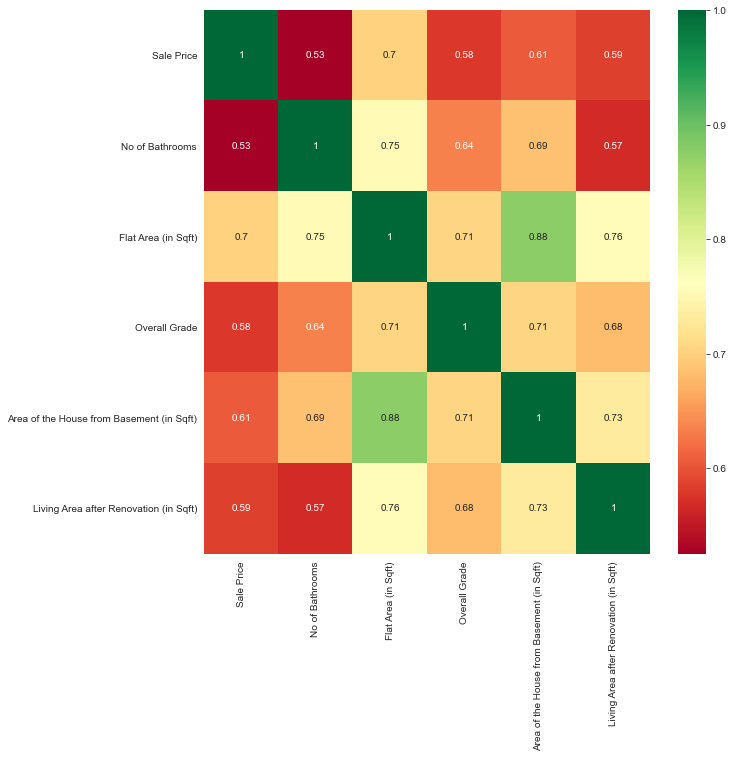

In [536]:
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat['Sale Price']) > 0.5]
plt.figure(figsize = (10,10))
g = sns.heatmap(df[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')

## Checking and Removing Multicollinearity

In [505]:
X.corr()

,No of Bedrooms,No of Bathrooms,Flat Area (in Sqft),Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Waterfront View_No,Waterfront View_Yes,No of Times Visited_0,No of Times Visited_1,No of Times Visited_2,No of Times Visited_3,No of Times Visited_4,Condition of the House_Bad,Condition of the House_Excellent,Condition of the House_Fair,Condition of the House_Good,Condition of the House_Okay,Ever Renovated_No,Ever Renovated_Yes
No of Bedrooms,1.000000,0.450405,0.599188,0.203214,0.133281,0.285065,0.474410,0.260366,-0.139611,-0.164918,-0.073144,0.168378,0.382331,0.193601,-0.009873,0.015967,-0.015967,-0.027421,0.012600,0.017462,0.019650,-0.000984,-0.014766,0.027710,-0.008609,-0.001157,-0.031940,-0.018364,0.018364
No of Bathrooms,0.450405,1.000000,0.684423,-0.075086,0.516943,0.587865,0.598807,0.205950,-0.540534,-0.207965,-0.033946,0.237852,0.494826,-0.082946,-0.005918,-0.012255,0.012255,-0.078747,0.023617,0.043431,0.062056,0.025360,-0.028448,-0.033421,0.196405,-0.178722,-0.062790,-0.044572,0.044572
Flat Area (in Sqft),0.599188,0.684423,1.000000,0.169784,0.326190,0.643353,0.818474,0.390756,-0.290078,-0.181288,-0.002754,0.225660,0.698557,0.151230,0.020037,-0.025418,0.025418,-0.157561,0.062954,0.087764,0.102216,0.059015,-0.022940,-0.008132,0.086546,-0.076241,-0.059978,-0.053871,0.053871
Lot Area (in Sqft),0.203214,-0.075086,0.169784,1.000000,-0.405196,-0.016787,0.133983,0.074709,0.074469,-0.252702,-0.147170,0.252510,0.228712,0.874239,0.003373,-0.038322,0.038322,-0.029144,0.026583,0.004386,0.008496,0.034241,0.004888,0.011154,-0.184892,0.189511,0.020233,0.010613,-0.010613
No of Floors,0.133281,0.516943,0.326190,-0.405196,1.000000,0.467707,0.527172,-0.289715,-0.498411,-0.050767,0.025013,0.096946,0.233518,-0.414648,0.003440,-0.009048,0.009048,0.007461,-0.024475,-0.009162,0.015584,0.011285,-0.017021,-0.119217,0.320231,-0.263210,-0.045867,-0.007867,0.007867
Overall Grade,0.285065,0.587865,0.643353,-0.016787,0.467707,1.000000,0.646184,0.060185,-0.448116,-0.154694,0.086327,0.169451,0.601484,-0.016683,-0.024052,-0.016787,0.016787,-0.135586,0.031928,0.084333,0.095850,0.051038,-0.037617,-0.099281,0.205416,-0.144088,-0.077067,-0.018924,0.018924
Area of the House from Basement (in Sqft),0.474410,0.598807,0.818474,0.133983,0.527172,0.646184,1.000000,-0.208447,-0.423492,-0.277051,-0.084743,0.360905,0.672429,0.119252,0.006643,-0.014755,0.014755,-0.054100,0.011393,0.025543,0.047240,0.028680,-0.018235,-0.091782,0.192229,-0.140934,-0.048689,-0.017320,0.017320
Basement Area (in Sqft),0.260366,0.205950,0.390756,0.074709,-0.289715,0.060185,-0.208447,1.000000,0.185176,0.135369,0.131094,-0.194377,0.112566,0.066789,0.023472,-0.019634,0.019634,-0.182068,0.088963,0.109137,0.098354,0.054531,-0.009833,0.133568,-0.160847,0.095994,-0.024089,-0.063981,0.063981
Age of House (in Years),-0.139611,-0.540534,-0.290078,0.074469,-0.498411,-0.448116,-0.423492,0.185176,1.000000,0.343121,0.192424,-0.414721,-0.295546,0.054255,0.188111,-0.021364,0.021364,-0.100458,0.043294,0.072994,0.035619,0.036922,0.037900,0.243873,-0.386545,0.253455,0.058951,-0.216225,0.216225
Zipcode,-0.164918,-0.207965,-0.181288,-0.252702,-0.050767,-0.154694,-0.277051,0.135369,0.343121,1.000000,0.296761,-0.621490,-0.275140,-0.255426,0.061452,-0.034840,0.034840,-0.142227,0.063948,0.087281,0.072535,0.053272,0.007327,0.057165,0.029351,-0.072929,0.026325,-0.073884,0.073884


In [506]:
## pair of independent variables with correlation greater than 0.5
k = X.corr()
z = [[str(i),str(j)] for i in k.columns for j in k.columns if (k.loc[i,j] >abs(0.5))&(i!=j)]
z, len(z)

([['No of Bedrooms', 'Flat Area (in Sqft)'],
  ['No of Bathrooms', 'Flat Area (in Sqft)'],
  ['No of Bathrooms', 'No of Floors'],
  ['No of Bathrooms', 'Overall Grade'],
  ['No of Bathrooms', 'Area of the House from Basement (in Sqft)'],
  ['Flat Area (in Sqft)', 'No of Bedrooms'],
  ['Flat Area (in Sqft)', 'No of Bathrooms'],
  ['Flat Area (in Sqft)', 'Overall Grade'],
  ['Flat Area (in Sqft)', 'Area of the House from Basement (in Sqft)'],
  ['Flat Area (in Sqft)', 'Living Area after Renovation (in Sqft)'],
  ['Lot Area (in Sqft)', 'Lot Area after Renovation (in Sqft)'],
  ['No of Floors', 'No of Bathrooms'],
  ['No of Floors', 'Area of the House from Basement (in Sqft)'],
  ['Overall Grade', 'No of Bathrooms'],
  ['Overall Grade', 'Flat Area (in Sqft)'],
  ['Overall Grade', 'Area of the House from Basement (in Sqft)'],
  ['Overall Grade', 'Living Area after Renovation (in Sqft)'],
  ['Area of the House from Basement (in Sqft)', 'No of Bathrooms'],
  ['Area of the House from Basement 

### Calculating VIF

In [507]:
# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = X[:]

## Calculating VIF for every column
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)
VIF

No of Bedrooms                                  1.691539
No of Bathrooms                                 3.009820
Flat Area (in Sqft)                          1524.317201
Lot Area (in Sqft)                              4.450581
No of Floors                                    2.742532
Overall Grade                                   2.454240
Area of the House from Basement (in Sqft)    1352.778017
Basement Area (in Sqft)                       527.196846
Age of House (in Years)                         2.619274
Zipcode                                         1.843207
Latitude                                        1.204203
Longitude                                       1.984574
Living Area after Renovation (in Sqft)          2.539043
Lot Area after Renovation (in Sqft)             4.547669
Years Since Renovation                          2.559345
Waterfront View_No                                   inf
Waterfront View_Yes                                  inf
No of Times Visited_0          

In [508]:
def MC_remover(data):
  vif = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index = data.columns)
  if vif.max() > 5:
    print(vif[vif == vif.max()].index[0],'has been removed')
    data = data.drop(columns = [vif[vif == vif.max()].index[0]])
    return data
  else:
    print('No Multicollinearity present anymore')
    return data

In [509]:
for i in range(7):
  vif_data = MC_remover(vif_data)

vif_data.head()

Waterfront View_No has been removed
No of Times Visited_0 has been removed
Condition of the House_Bad has been removed
Ever Renovated_No has been removed
Flat Area (in Sqft) has been removed
Condition of the House_Fair has been removed
No Multicollinearity present anymore


,No of Bedrooms,No of Bathrooms,Lot Area (in Sqft),No of Floors,Overall Grade,Area of the House from Basement (in Sqft),Basement Area (in Sqft),Age of House (in Years),Zipcode,Latitude,Longitude,Living Area after Renovation (in Sqft),Lot Area after Renovation (in Sqft),Years Since Renovation,Waterfront View_Yes,No of Times Visited_1,No of Times Visited_2,No of Times Visited_3,No of Times Visited_4,Condition of the House_Excellent,Condition of the House_Good,Condition of the House_Okay,Ever Renovated_Yes
0,-0.328579,-1.491615,-0.384509,-0.855016,-0.460173,-0.679988,-0.688216,0.461744,1.744405,-0.363763,-0.130448,-0.923737,-0.395559,-0.152042,-0.042968,-0.114868,-0.187698,-0.116504,-0.071152,-0.301077,-0.600459,-0.082481,-0.19596
1,-0.328579,0.412139,0.110144,0.971719,-0.460173,1.021536,0.414320,0.594728,0.768469,1.138109,-0.661676,-0.221229,0.307212,5.092239,-0.042968,-0.114868,-0.187698,-0.116504,-0.071152,-0.301077,-0.600459,-0.082481,5.10309
2,-1.619032,-1.491615,0.967086,-0.855016,-1.569974,-1.384660,-0.688216,1.193156,-1.017679,1.259089,0.075188,1.846150,0.456670,-0.152042,-0.042968,-0.114868,-0.187698,-0.116504,-0.071152,-0.301077,-0.600459,-0.082481,-0.19596
3,0.961875,1.554391,-0.586471,-0.855016,-0.460173,-0.903421,1.820054,0.129284,0.971022,-0.295040,-1.295722,-0.883593,-0.625223,-0.152042,-0.042968,-0.114868,-0.187698,-0.116504,-0.071152,3.321413,-0.600459,-0.082481,-0.19596
4,-0.328579,0.031388,0.370520,-0.855016,0.649628,0.179367,-0.688216,-0.602129,-0.170640,0.392184,1.686008,-0.000441,0.259159,-0.152042,-0.042968,-0.114868,-0.187698,-0.116504,-0.071152,-0.301077,-0.600459,-0.082481,-0.19596


In [510]:
# Calculating VIF for remaining columns
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)
VIF, len(vif_data.columns)

(No of Bedrooms                               1.691486
 No of Bathrooms                              3.009738
 Lot Area (in Sqft)                           4.450003
 No of Floors                                 2.742403
 Overall Grade                                2.452138
 Area of the House from Basement (in Sqft)    4.266140
 Basement Area (in Sqft)                      2.060023
 Age of House (in Years)                      2.615988
 Zipcode                                      1.842991
 Latitude                                     1.204158
 Longitude                                    1.984379
 Living Area after Renovation (in Sqft)       2.537333
 Lot Area after Renovation (in Sqft)          4.547211
 Years Since Renovation                       2.559338
 Waterfront View_Yes                          1.391046
 No of Times Visited_1                        1.030601
 No of Times Visited_2                        1.056576
 No of Times Visited_3                        1.049701
 No of Tim

In [511]:
X = vif_data[:]

In [524]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sX, sy, test_size = 0.3, random_state = 101)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((11395, 29), (4884, 29), (11395,), (4884,))

In [525]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)

LinearRegression(normalize=True)

In [526]:
predictions = lr.predict(x_test)

In [527]:
lr.score(x_test, y_test)

0.7314684230657722

In [528]:
residuals = predictions - y_test

residual_table = pd.DataFrame({'residuals':residuals,
                    'predictions':predictions})
residual_table = residual_table.sort_values( by = 'predictions')

In [529]:
z = [i for i in range(int(residual_table['predictions'].max()))]
k = [0 for i in range(int(residual_table['predictions'].max()))]

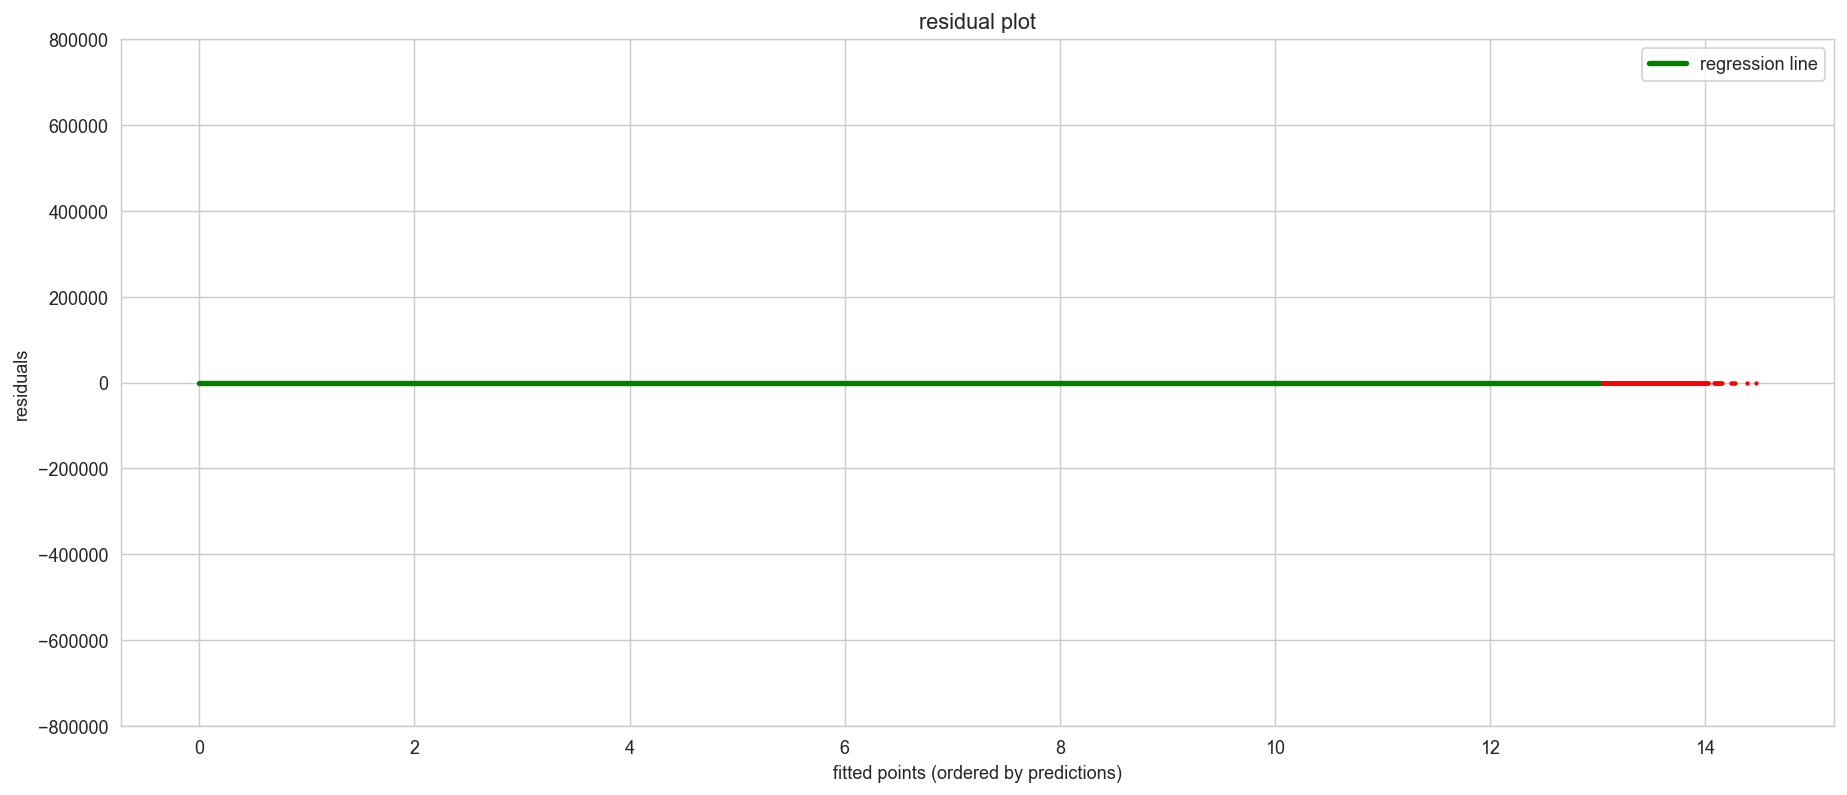

In [530]:
plt.figure(dpi = 130, figsize = (17,7))

plt.scatter( residual_table['predictions'], residual_table['residuals'], color = 'red', s = 2)
plt.plot(z, k, color = 'green', linewidth = 3, label = 'regression line')
plt.ylim(-800000, 800000)
plt.xlabel('fitted points (ordered by predictions)')
plt.ylabel('residuals')
plt.title('residual plot')
plt.legend()
plt.show()

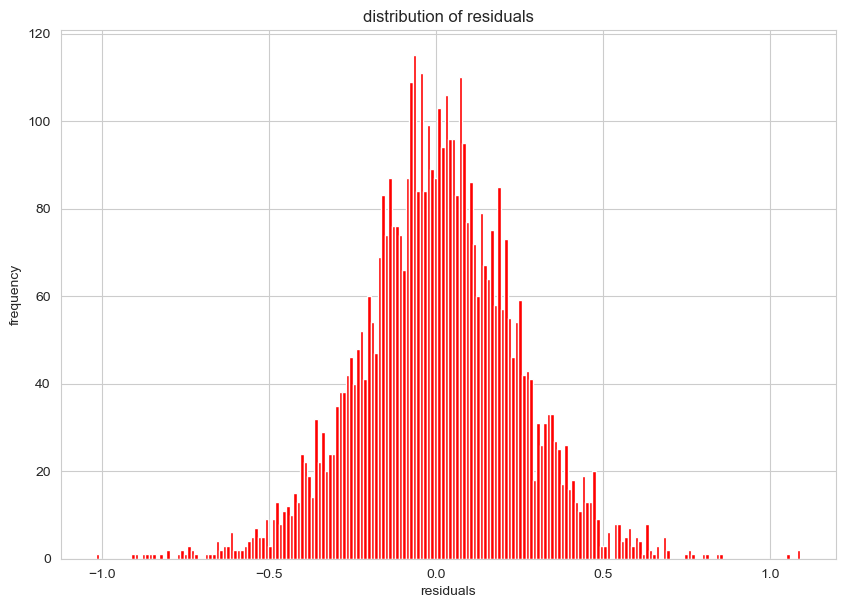

In [531]:
plt.figure(dpi = 100, figsize = (10,7))
plt.hist(residual_table['residuals'], color = 'red', bins = 200)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title('distribution of residuals')
plt.show()

In [532]:
coefficients_table = pd.DataFrame({'column': x_train.columns,
                                  'coefficients': lr.coef_})
coefficient_table = coefficients_table.sort_values(by = 'coefficients')


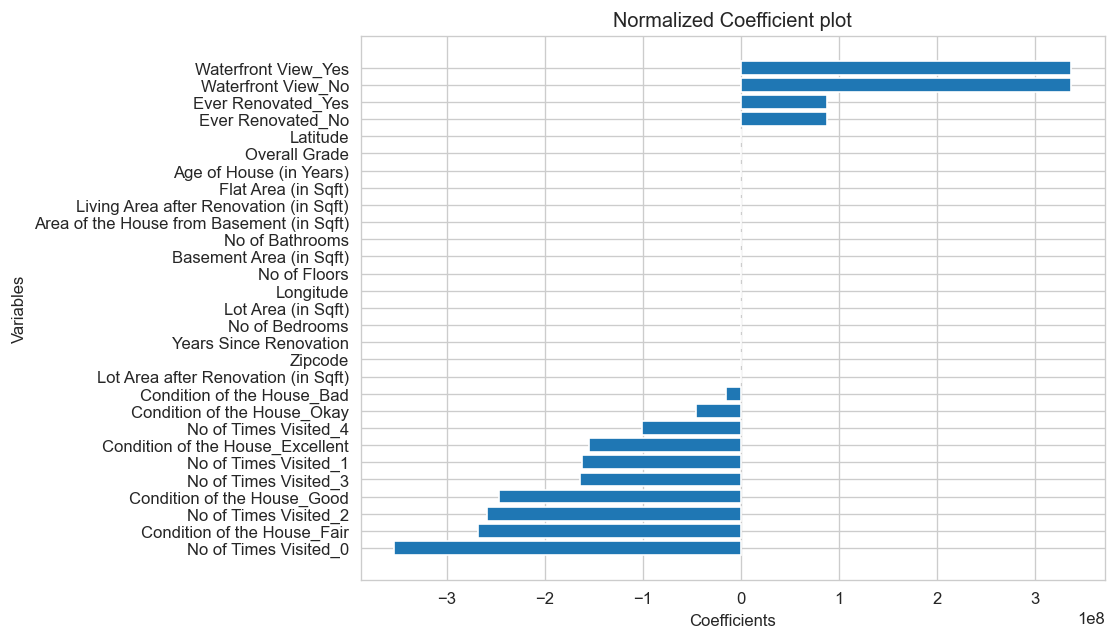

In [533]:
plt.figure(figsize=(8, 6), dpi=120)
x = coefficient_table['column']
y = coefficient_table['coefficients']
plt.barh( x, y)
plt.xlabel( "Coefficients")
plt.ylabel('Variables')
plt.title('Normalized Coefficient plot')
plt.show()